In [1]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Paso 2: Leemos el  Data Set

In [2]:
url = 'https://github.com/VictorHugo1320/Tesis-2024-UNIR/raw/main/Bank_Personal_Loan_Modelling.xlsx'
df = pd.read_excel(url, sheet_name='Data')
df.head(5)

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

## Paso 3: Realizamos un analísis univariante del DataSet 

In [3]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Resultados obtenidos del perfil de reporte

<font color='blue'> Información Básica del DataSet </font> <br>
* El dataset tiene **5000** clientes.
* Tenemos **14 variables** incluyendo **13 variables independientes** y **1 variable dependiente** la cual es **Crédito Personal**
* Tenemos **6 variables numéricas**: ID , Age , Experience , Income , CC_Avg , Mortgage
* Tenemos **3 variables categóricas**: Family , Education , Zip_Code

Tenemos **5 variables booleanas**: Personal_Loan , Securities Account , CD_Account , Online , Credit_Card
No hay **valores faltantes** en el dataset.
No hay **valores duplicados** en el dataset.
El dataset contiene valores negativos para **Experiencia**, lo cual is irrazobable.
* **ID** se distribuye uniformemente. Por lo tanto, ID actúa como identificador y carece de información valiosa para el modelo.
* **ZIP Code** contiene una gran cantidad de categorías (467 categorías). Por lo tanto, parece que carece de mucha información para nuestro modelo.<br>

<font color='blue'> Análisis de variables categóricas: </font> <br>

* **Education -** 42% de los candidatos tienen una licenciatura y el 30% tiene una maestría y el 28% son profesionales. <br>

* **Family** - Aproximadamente el 29% del tamaño de la familia del cliente es 1, el 26% es 2, el 20% es 3 y el 24% es 4. <br>

<font color='blue'> Boolean Variables Analysis: </font> <br>

* **Personal Loan** - Alrededor del 90% de los clientes no aceptaron el préstamo personal ofrecido en la última campaña . El conjunto de datos está **desequilibrado!**

* **CD Account** - 94% de los clientes no tienen una cuenta de depósito en el banco.
* **CreditCard** - Alrededor del 71% de los clientes no utilizan tarjetas de crédito.
* **Online** - Alrededor del 60% de los clientes utilizan las instalaciones de la banca por internet
* **Securities Account** - Alrededor del 90% de los clientes no tienen una cuenta de valores con el banco <br>

<font color='blue'> Análisis de Variables Numéricas: </font> <br>

* **Age** - La edad promedio de los clientes es de 45 años con una desviación estándar de 11,5. La curva del histogram es bastante simétrica. 
* **CCAvg** - El promedio de gasto en las tarjestas de crédito por mes es de 1,94 con una desviación estándar de 1,75. La curva está altamente sesgada positivamente.
* **Income** - El ingreso anual promedio del cliente es de 73,77 con una desviación estándar de 46. La curva está moderadamente sesgada positivamente. 
* **Mortgage** - El valor promedio de la hipoteca de la casa es de 56,5 con una desviación estándar de 101,71. La curva está altamente sesgada positivamente (Sesgo=2,1) y hay muchos valores atípicos (Curtosis = 4,76) <br>

Como se puede observar, el ID tiene una distribución uniforme. Los valores del ID son todos únicos y en realidad el ID actúa como un identificador y carece de información valiosa para el modelo. Por lo tanto, eliminamos esta característica. 



In [4]:
df.drop('ID', axis=1, inplace=True) 

Eliminamos la variable **"ID"**.

## Paso 4. Analísis de Correlacción

Comparemos la correlación **Spearman** con la correlación de **Pearson** : <br>
* Pearson works with a linear relationship between the two variables whereas the Spearman works with monotonic relationships as well.
*Pearson works with raw data values of the variables whereas Spearman works with rank-ordered variables. <br>

When the variables have a "might be monotonic, might be linear" relationship, our best bet is to use Spearman rather than Pearson:


In [5]:
# Definimos el Mapa de Colores
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

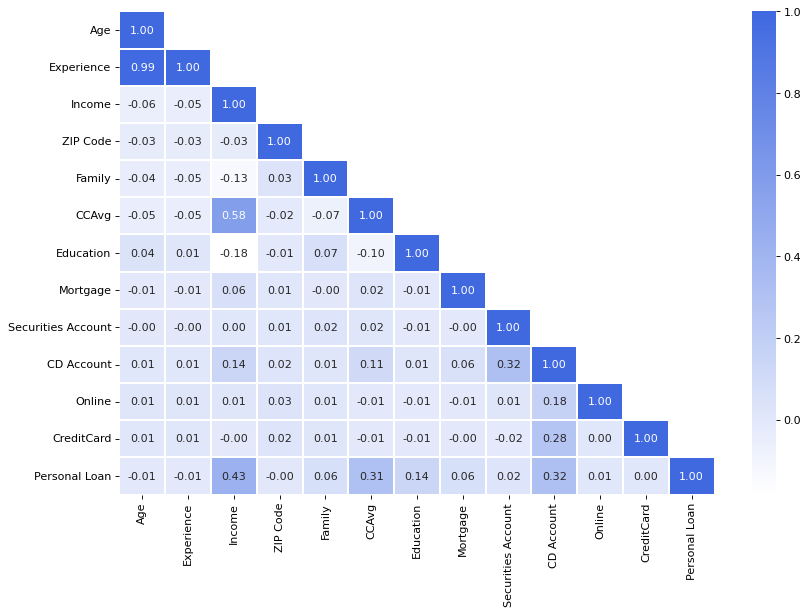

In [6]:
# Calculamos la correlación de Sperman
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Creamos una máscara para que veamos los valores de correlación solo una vez 
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Graficamos el mapa de calor de correlación
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

Conclusión: <br>

* **Personal Loan** está altamente correlacionado con **Income, CD_Account, CCAvg.**
* **Experience** está altamente correlacionado con **Age.** (ρ = 0.99)
* **CCAvg** está altamente correlacionado con **Income** to a good extent. (ρ = 0.58)

## Paso 5: Data Cleansing

**Data cleansing**, también conocido como limpieza de datos, es el proceso de preparar y estructurar datos sin procesar para su uso en análisis posteriores. Incluye identificar y corregir datos incorrectos o incompletos, eliminar datos irrelevantes, completar valores faltantes y transformar variables existentes. La limpieza de datos es un paso esencial en cualquier proyecto de aprendizaje automático porque ayuda a mejorar la precisión de un modelo al reducir el ruido y los errores. Los datos mal limpiados pueden llevar a modelos excesivamente complejos que son difíciles de interpretar y tienen una alta probabilidad de sobreajuste. Además, los datos sucios pueden reducir significativamente la precisión de un modelo; incluso una pequeña cantidad de ruido disminuirá drásticamente su rendimiento.”

#### Paso 5.1: Tratamiento de ruido
El tratamiento de ruido es el proceso por el cual se elimina las secciones irrelevates o ruidosas de un conjunto de datos antes de que se puedan utilizar para el análisis. 

#### I) Tratamiento de Ruido en la variable Experience
Como se observa, el conjunto de datos tiene valores negativos en la variable *Experience*. Teniendo en cuenta que los valores de esta variable indican la experiencia laboral en años, estos valores se consideran ruido. 

In [7]:
df[df['Experience']<0]['Experience'].count()

52

Conteo de valores negativos únicos.  

In [8]:
df[df['Experience']<0]['Experience'].value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

Dado que el número de estos valores de ruido en la característica de Experiencia es pequeño, asumimos que estos valores se registraron incorrectamente como negativos y los reemplazamos por su valor absoluto.

In [9]:
df['Experience'] = df['Experience'].apply(abs)

### Paso 5.2: Tratamiento de Valores Atípicos 
**Valores atípicos** son puntos de datos que son significativamente más altos o más bajos que la mayoría de los otros valores en el conjunto. <br>
**Curtosis** es la medida de las "colas" o forma de una distribución. Si el valor de curtosis es mayor que 3, es probable que la variable contenga valores atípicos. Esto se debe a que una curtosis excesiva indica que los puntos de datos tiene una concentración más alta en las colas que lo normal, lo que puede indicar la presencia de valores atípicos. <br> <br>

En el tercer paso, de todas las características continuas, solo la característica **Hipoteca** tuvo un valor de curtosis superior a 3. Para detectar posibles valores atípicos en esta característica. 

Veamos de nuevo la distribución de la variable **Hipoteca**.

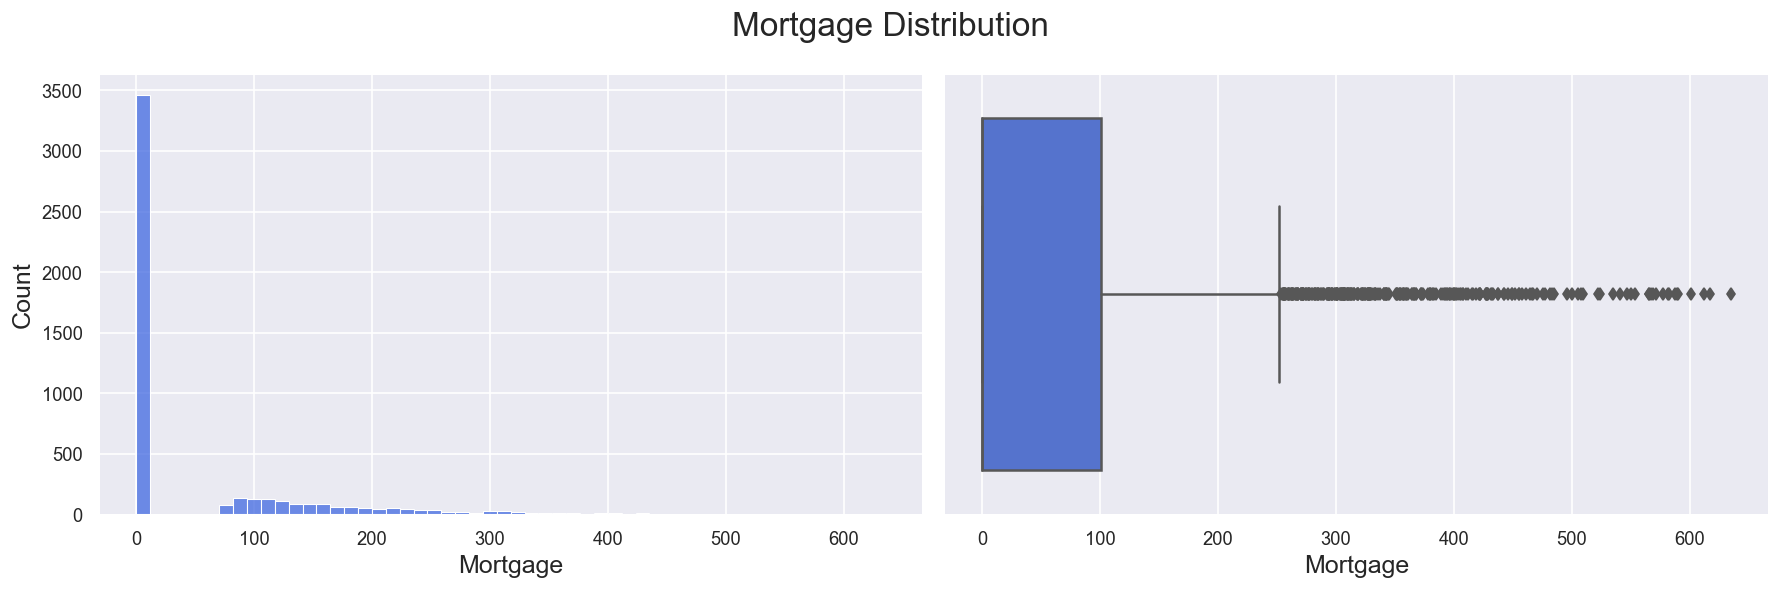

In [10]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

El método **Z-score** para la detección de valores atípicos es una técnica estadística utilizada para detectar valores atípicos en conjuntos de datos mediante el cálculo de cuántas desviaciones estándar se encuentra cada punto de datos lejos de la media. Un punto de datos con un puntaje Z de más de 3 desviaciones estándar lejos de la media se considera un valor atípico. Utilizamos el módulo **scipy.stats** para realizar la técnica de puntuación Z.  

In [11]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

Encontramos 105 registros con un valor de hipoteca de puntuación Z mayor que 3. Por lo tanto, consideramos estos 105 registros con valores atípicos y los filtramos de nuestro conjunto de datos 

In [12]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

### 5.3 Tratamiento de Missing Values

In the 3rd step, we found that our dataset does not contain any **missing values.** Now let us check again if there is any missing value:

In [13]:
df.isnull().sum().sum()

0

Es claro que el conjunto de datos no tiene valores faltantes. 

### 5.4 Tratamineto de Valores Duplicados

**Duplicate Values Treatment** es el proceso de eliminar registros duplicados del conjunto de datos antes de alimentarlos en un algoritmo de aprendizaje automático. Esto es para asegurarse de que solo se usen muestras únicas para entrenar y evaluar el algoritmo de aprendizaje automático. 

In [14]:
df[df.duplicated(keep=False)].sum().sum()

0.0

## Paso 6. Analísis Bivariante 

Después de haber considerado cada variable individualmente en el análisis univariado en el Paso 3, ahora los examinaremos nuevamente con respecto a la Variable Objetivo. 

Primero, identificaremos la relación entre la Variable Objetivo y las Características Categóricas. Luego, veremos las Características Numéricas en comparación con la variable Objetivo. 

### 6.1: Variables Catégoricas vs Variable Dependiente

En esta parte, crearemos gráficos de barras y columnas apilados al 100% que muestran la proporción de préstamos tomados y no tomados por cada variable categórica por separado. 

In [15]:
# Definimos una lista que incluya los nombres de las características categóricas relevantes presentes en el conjunto de datos 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define el nombre del objetivo en una variable para simplificar
Target = 'Personal Loan'

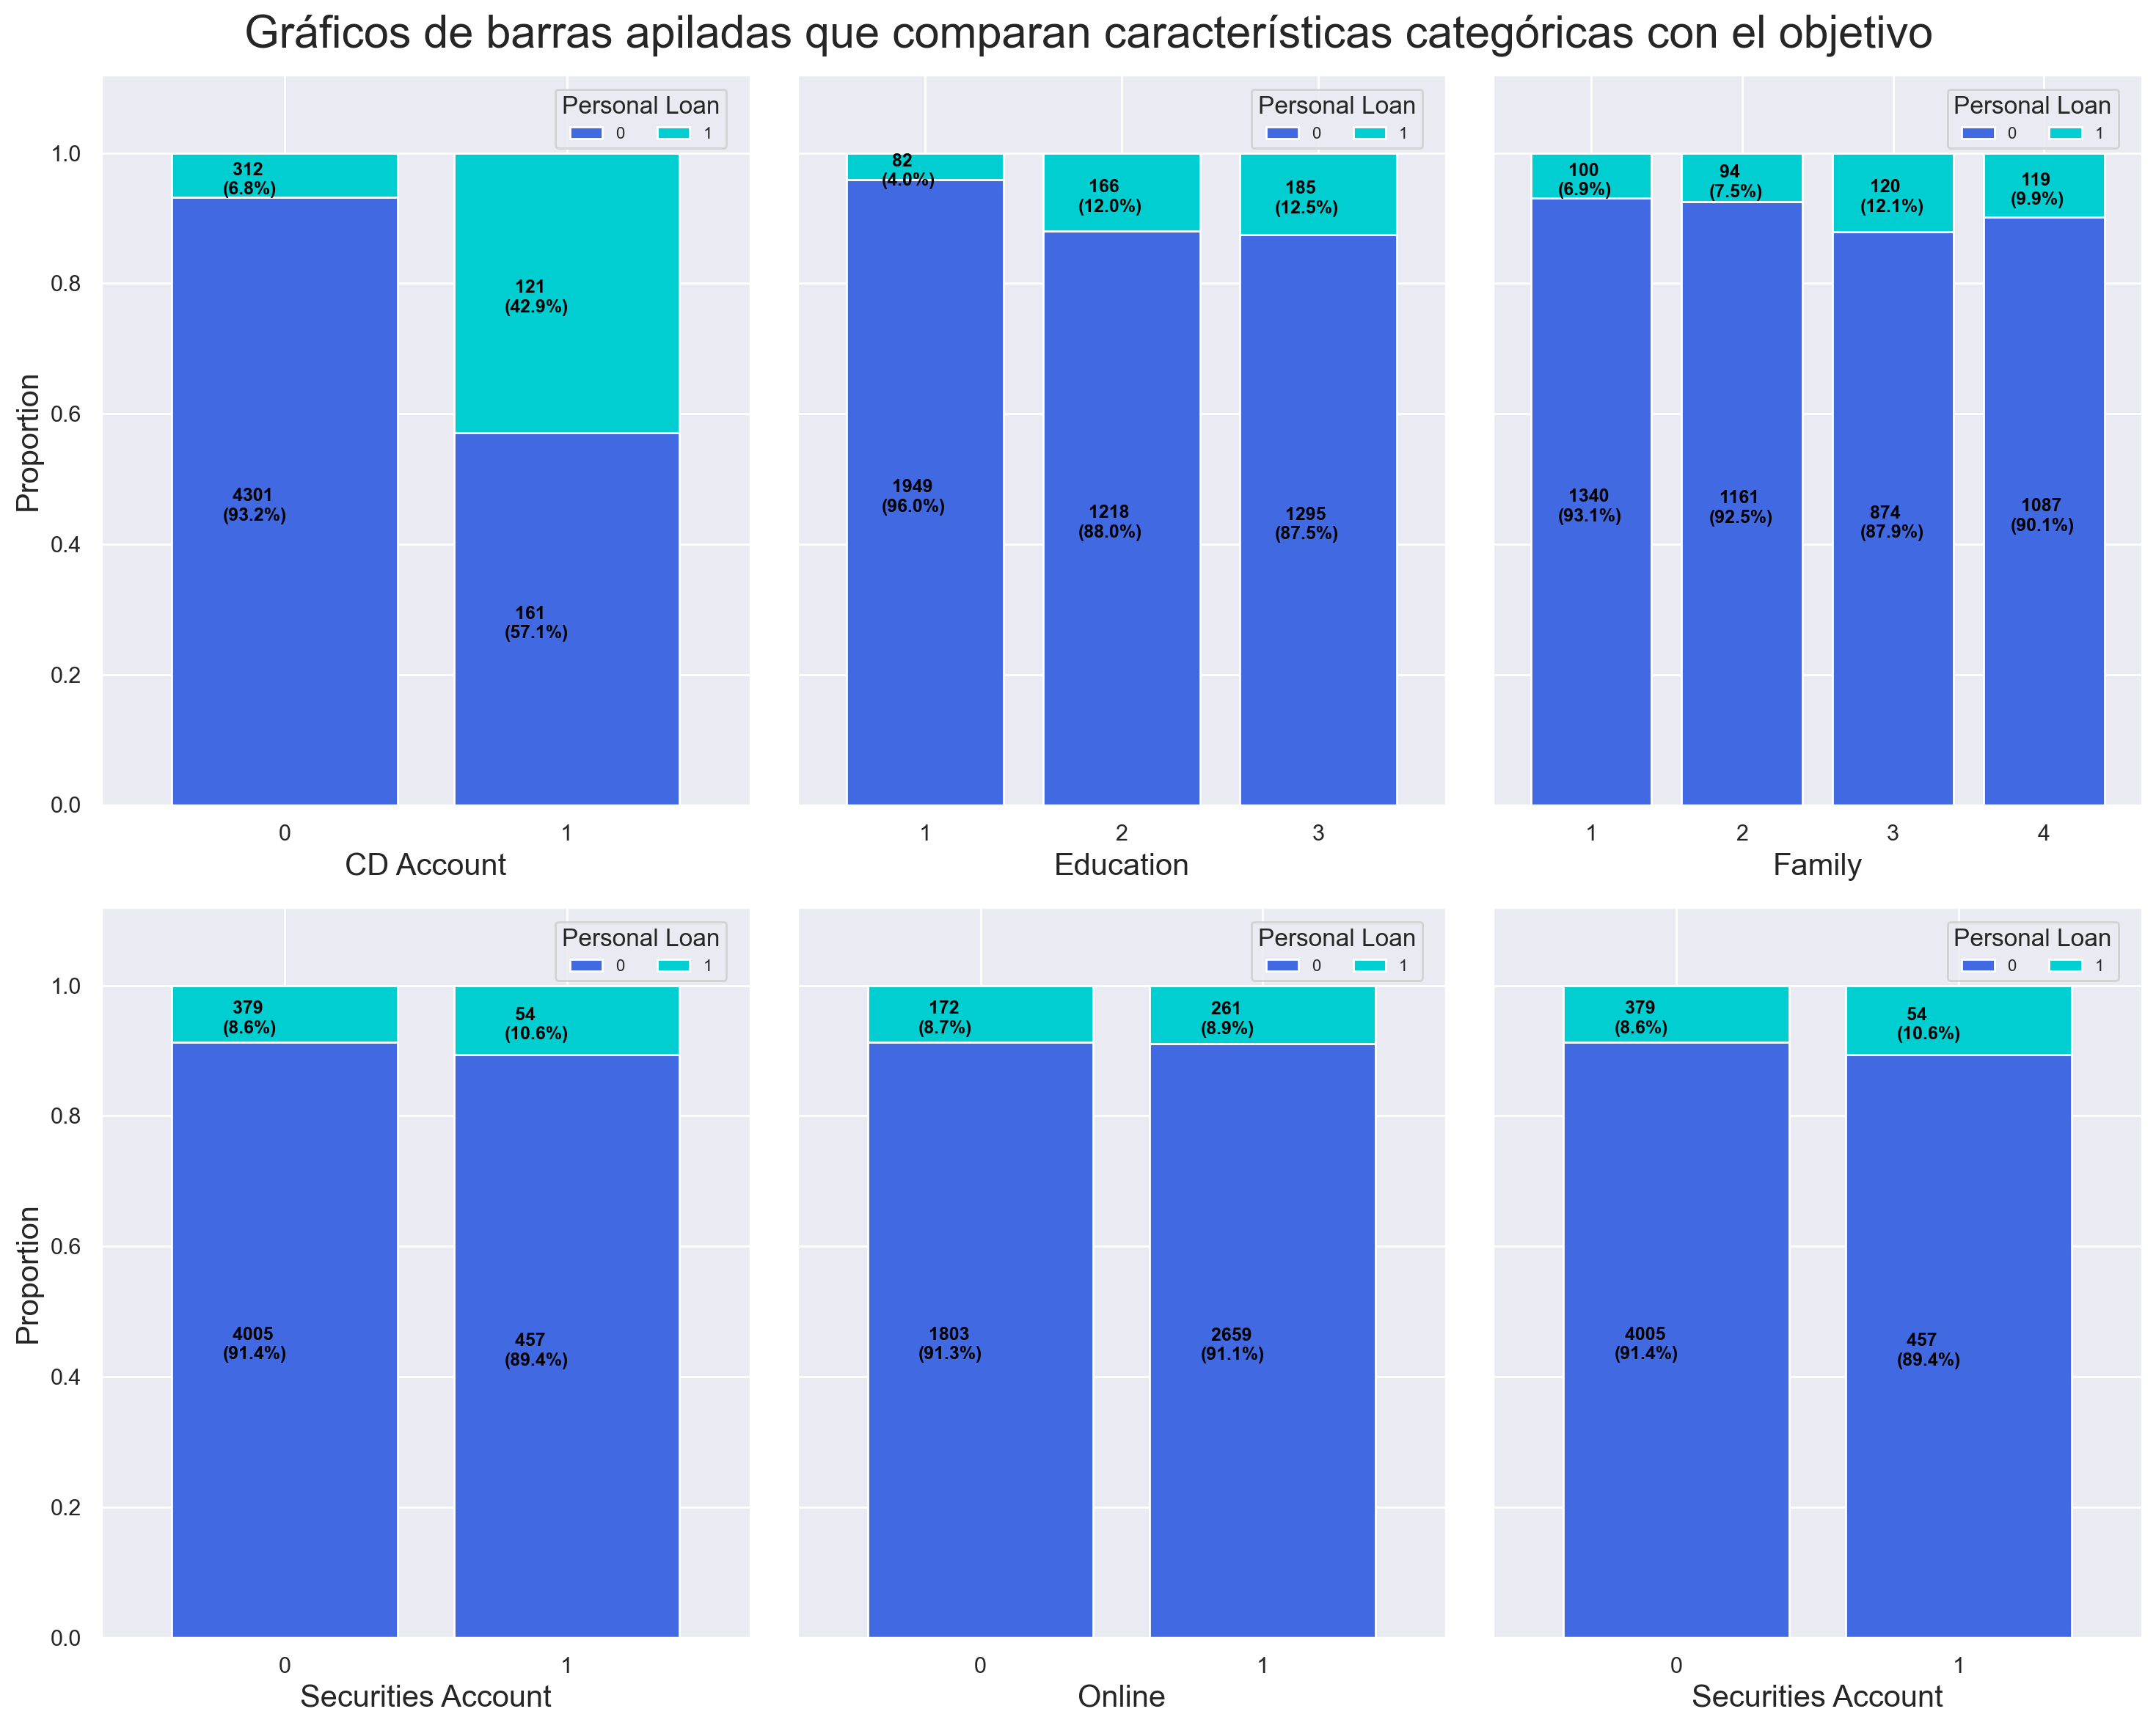

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Genera una tabla cruzada que muestre la proporción de préstamos tomados y no motados para cada categoría de la variable
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Usar el argumento normalize=True nos brinda la proporción de los datos por índice
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Definimos colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # graficar barras apiladas
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Añade las proporciones y los recuentos de las barras individuales a nuestro gráfico
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Añadimos la Leyenda
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Establecemos el límite de y
    ax[x,y].set_ylim([0,1.12])
    # Rotar xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Gráficos de barras apiladas que comparan características categóricas con el objetivo', fontsize=22)
plt.tight_layout()                     
plt.show()

**Conclusión:**

* El cliente que tiene un certificado de depósito (CD) con el banco parece tomar prestamos personales del banco. <br>
* Los clientes con altos niveles de educación son más propensos a tomar préstamos personales. <br> 
* El número de mienbros de la familia no tiene un efecto significativo en la probabilidad de tomar préstamos personales. <br>
* Los clientes que tienen o no tienen una cuenta de valores en el banco no tienen influencia en la probabilidad de tomar un préstamo personal. <br>
* El cliente que usa o no banca por internet no parece tener ninguna influencia en la probabilidad de tomar un préstamo personal. <br> 
* El cliente que usa o no usa una tarjeta de crédito no parece tener un impacto en la probabilidad de comprar un préstamo personal. <br>

### Paso 6.2: Características Númericas vs Objetivo

En esta parte, intentaremos encontrar la **media** y **distribución** de las características numéricas para las cuales los clientes toman un préstamo personal en comparación con la media y distribución de las características numéricas de aquellos que no lo hacen. 

In [18]:
# Definimos una lista que contenga los nombres de las características numéricas importantes en el conjunto de datos 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

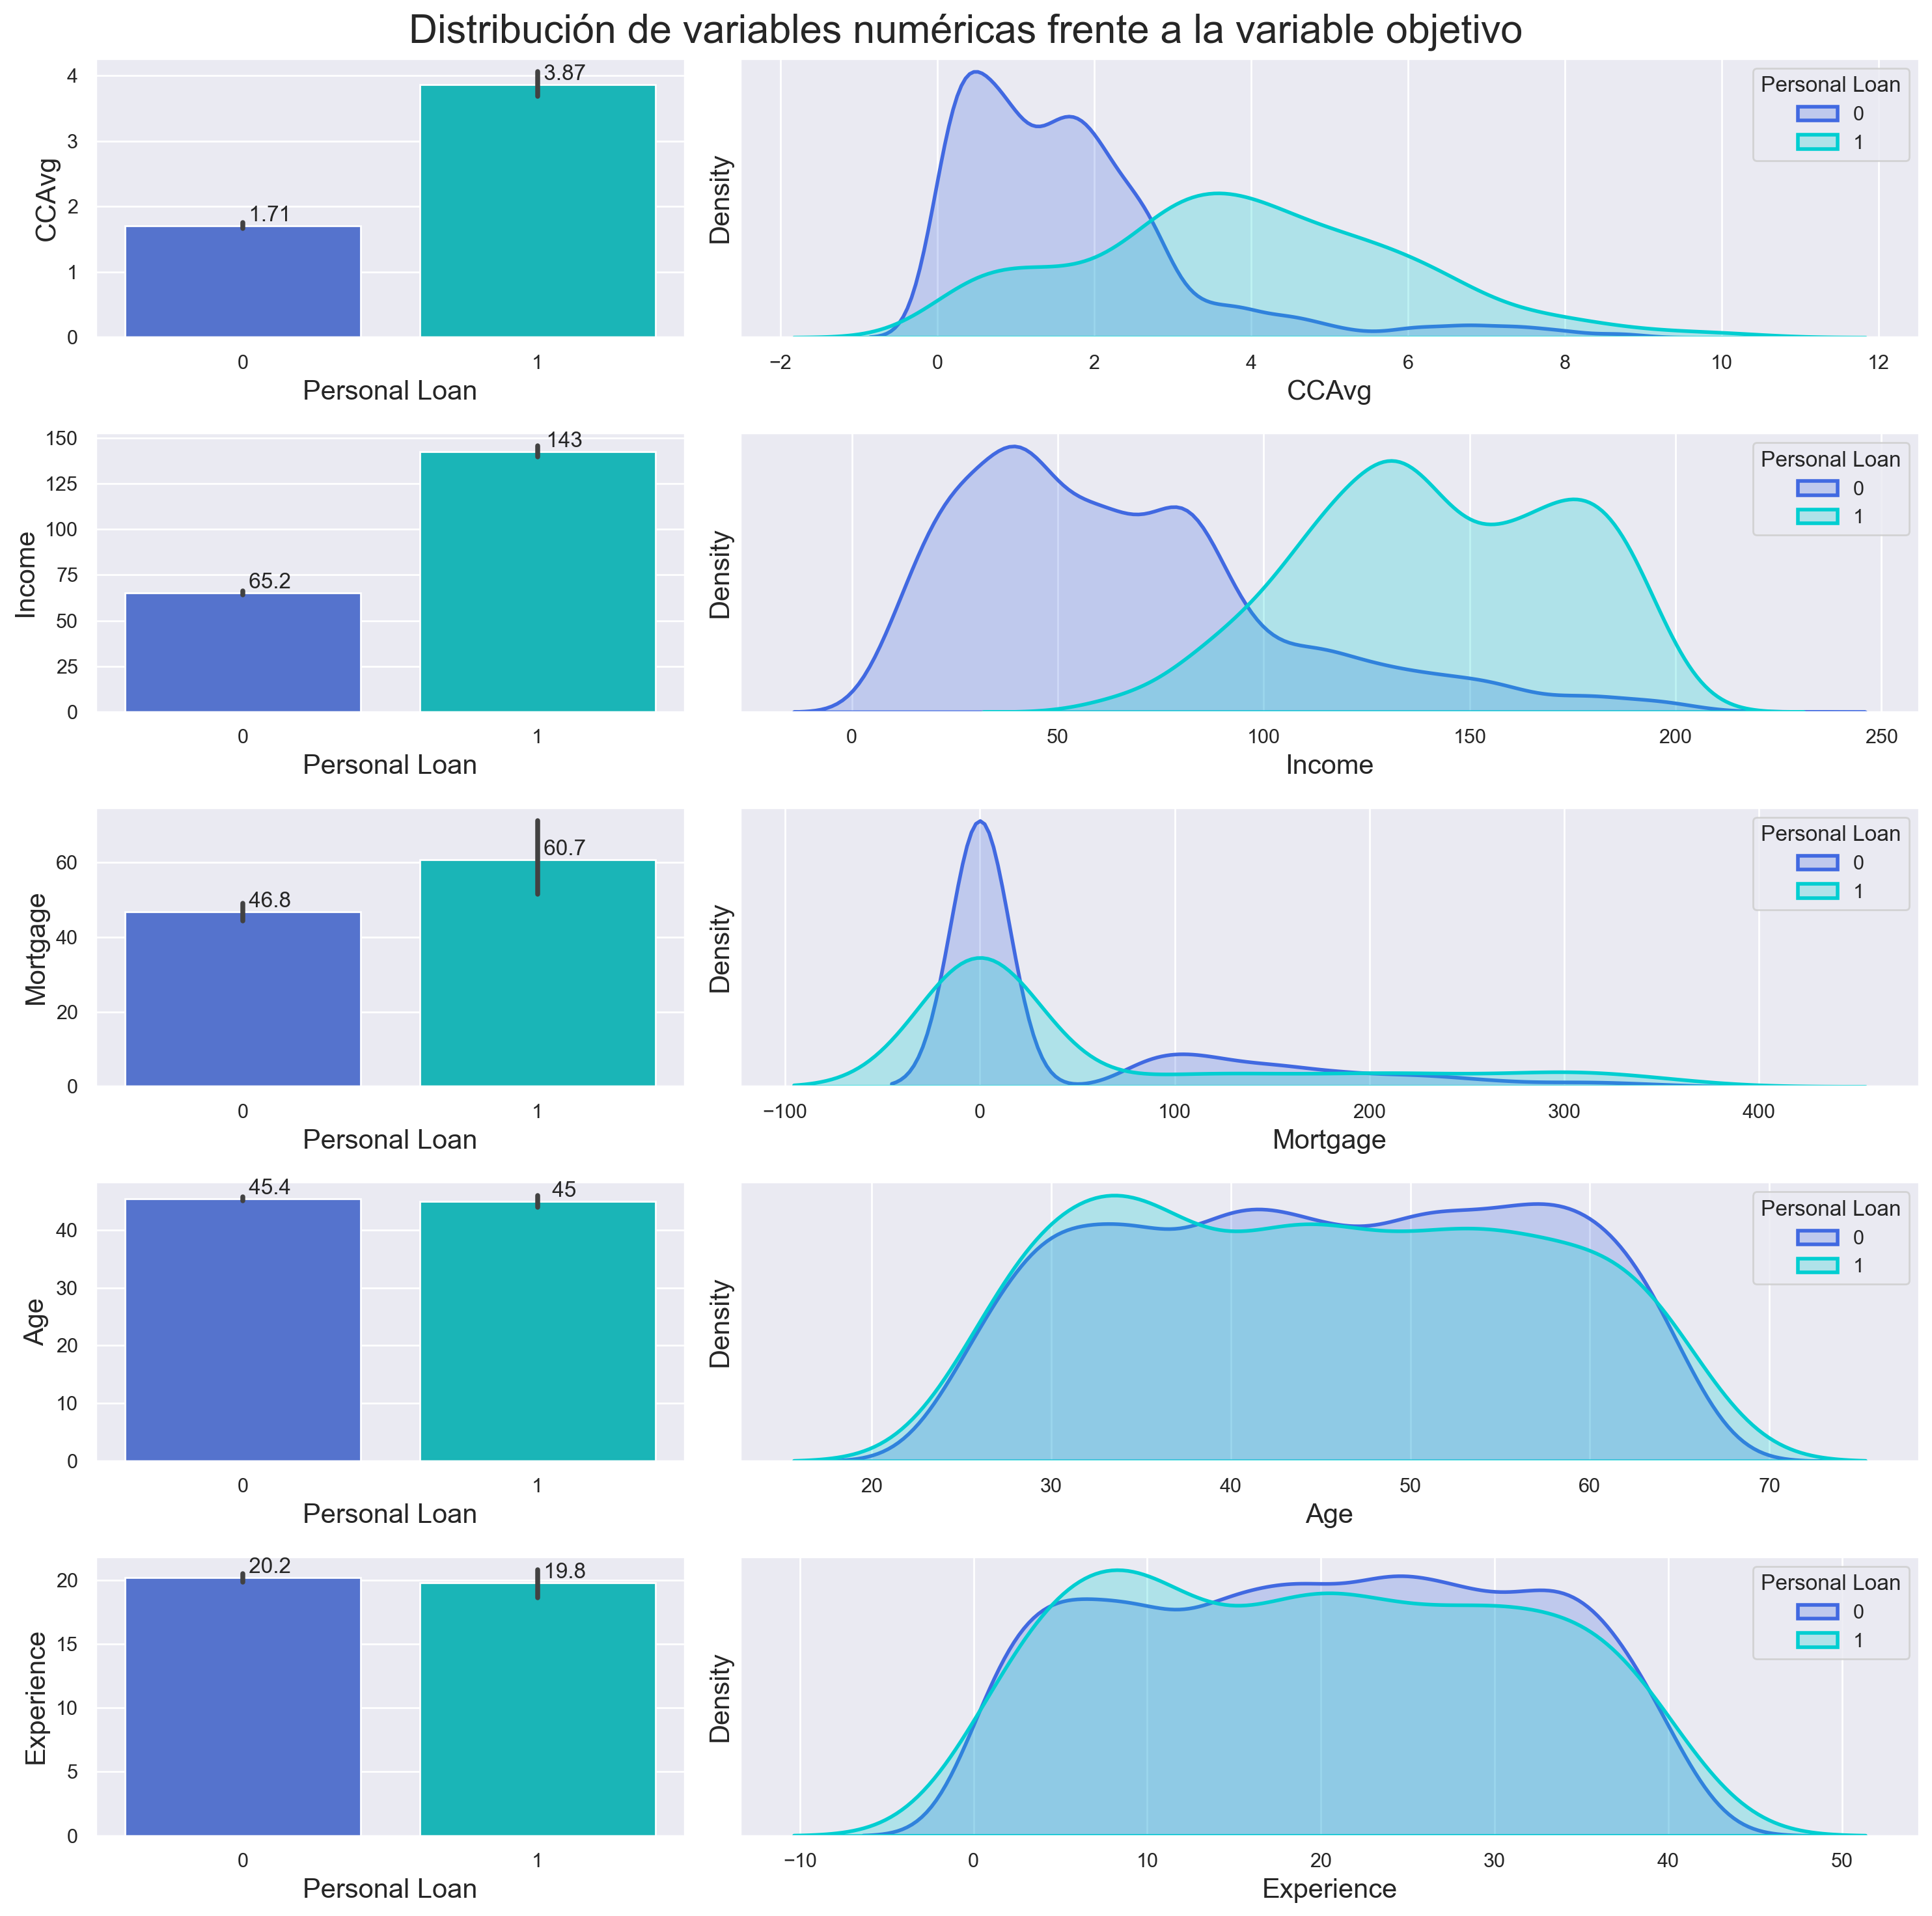

In [19]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Agregamos los tamaños de las barras a nuestro gráfico
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Distribución de variables numéricas frente a la variable objetivo', fontsize=22)
plt.tight_layout()                     
plt.show()

**Conclusión**
* Los clientes que gastan más en tarjetas de crédito son más propensos a solicitar préstamos personales. 
* Los clientes con ingresos altos son más propensos a tomar un préstamo personal. 
* Los clientes con un alto valor hipotecario son más propensos a tomar préstamos personales. 
* Se puede inferir que la edad de los clientes no tiene influencia en la probabilidad de adquirir préstamos personales. 
* El efecto de la cantidad de experiencia laboral en adquirir un préstamo es similar al de la edad del cliente. La distribución de la experiencia es muy similar a la distribución de la edad, ya que la experiencia está fuertemente correlacionada con la edad. <br>

Por lo tanto, eliminamos la experiencia porque no proporciona más información que la edad:

In [20]:
df.drop('Experience', axis=1, inplace=True)

### Paso 7: Train Test Split

En primer lugar, es necesario definir las características **(X)** y las etiquetas de salida **(Y)** del conjunto de datos dado. **X** es un marco de datos que contiene los diferentes valores de características para todas las observaciones dadas, mientras que **Y** es una serie que contiene las etiquetas categóricas que pertenecen a cada observación.



In [21]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

Necesitamos realizar una **train test** y prueba en el aprendizaje automático supervisado para evaluar el rendimiento de un modelo después de haber sido entrenado. El conjunto de datos se divide típicamente en dos partes: el conjunto de entrenamiento, que se utiliza para entrenar el modelo, y el conjunto de prueba, que se utiliza para medir qué tan bien el modelo se desempeña en nuevos datos. La división de entrenamiento y prueba nos permite evaluar la capacidad de generalización del modelo al verificar su rendimiento en datos no vistos. Esta técnica se puede utilizar para identificar cualquier sesgo y varianza en el modelo y asegurarse de que se generalice bien en ejemplos no vistos.

### Datos Desbalanceados:

Un conjunto de datos desequilibrado es un conjunto de datos donde las clases no están equilibradas o son iguales. Esto significa que hay una cantidad desigual de muestras de cada clase objetivo y algunas clases pueden tener significativamente más muestras que otras.

Como vimos en el tercer paso, el conjunto de datos en el que estamos trabajando es un conjunto de datos desequilibrado. Verifiquemoslo nuevamente.

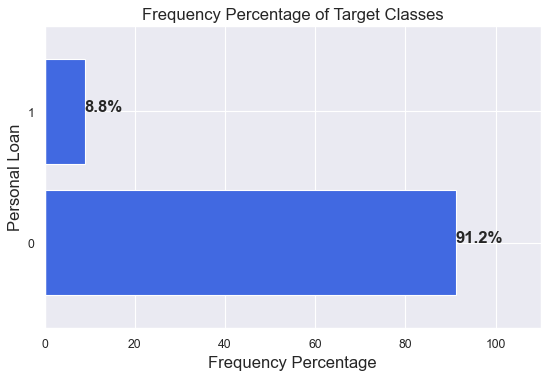

In [22]:
plt.figure(dpi=80)

# Gráfico de barras apiladas que muestra los porcentajes de frecuencia
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Agregamos porcentajes de frecuencia a la gráfica
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

Como podemos observar, **el conjunto de datos en el que estamos trabajando está desequilibrado.**

### Problemas con el conjunto de datos desequilibrados:

1. Los conjuntos de datos desequilibrados pueden llevar a algoritmos que están sesgados hacia la clase mayoritaria. Esto significa que cualquier algoritmo de clasificación entrenado en un conjunto de datos desequilibrados a menudo clasificará incorrectamente las clases minoritaria. 

2. El rendimiento de un modelo de aprendizaje automático puede ser altamente sesgado cuando se alimenta con datos desequilibrados. Por ejemplo, nuestro conjunto de datos tiene un 91,2% de la clase 0 y un 8,8% de la clase 1, entonces el modelo de aprendizaje podría ser fácilmente optimizado para predecir que todas las entradas de pruebas pertenecen a la clase 0 y aún así obtener una precisión del 91,2%. 

3. Si un modelo se entrena con datos que están muy desequilibrados, puede desarrollar una comprensión incorrecta de las tendencias subyacentes en los datos. El modelo puede no ser capaz de reconocer cómo se distribuyen ciertos valores entre diferentes clases o incluso cómo ciertas clases se superponen entre sí. 

### Técnicas para manejar conjunto de datos desequilibrados

#### <font color='royalblue'> 1. El enfoque para la división de entrenamiento y prueba: </font> 

El enfoque para la división de entrenamiento y prueba cuando se trata de conjuntos de datos desequilibrados es utilizar la **estratificación**. La estratificación es un paso importante en la división de conjuntos de datos desequilibrados en conjuntos de entrenamiento y prueba. La estratificación garantiza que la proporción de cada clase se mantenga igual en ambos conjuntos de entrenamiento y prueba. Esto es importante ya que permite una evaluación más precisa del modelo, evitando el sesgo debido a una desproporción de una clase que esté sobrerepresentada en cualquiera de los conjuntos de datos. El muestreo estratificado también asegura que cualquier tendencia o correlación entre diferentes clases que exista dentro del conjunto de datos general se preserve después de la división en conjuntos de entrenamiento y prueba. 


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Veamos la proporción de cada clase en ambos conjuntos de entrenamiento y prueba

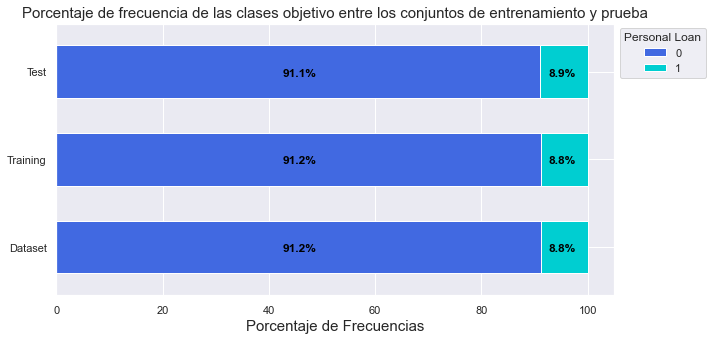

In [25]:
# Definimos un dataframe que contenga porcentajes de frecuencia.
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Realizamos un gráfico de barras con porcentajes de frecuencia.
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Añadimos los porcentajes a nuestro gráfico
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Porcentaje de Frecuencias', fontsize=15)
plt.title('Porcentaje de frecuencia de las clases objetivo entre los conjuntos de entrenamiento y prueba', fontsize=15)
plt.show()  

Como se puede observar, las muestras se dividen aleatoriamente de tal manera que la proporción de cada clase permanece igual en ambos conjuntos de entrenamiento y prueba

#### <font color='royalblue'> 2. El enfoque para la evaluación del modelo: </font>  <br>
El enfoque para la **evaluación del modelo** al tratar con **conjunto de datos desequilibrados** es utilizar métricas apropiadas, incluyendo **recall, precision, F1 score y AUC (área bajo la curva)** que son más adecuadas al tratar con conjuntos de datos desequilibrados en lugar de las métricas de precisión tradicionales que no tienen en cuenta el desequilibrio de clases de forma predeterminada. <br>

En este proyecto, el objetivo principal es clasificar a los clientes potenciales que son más propensos a tomar un préstamo. Las métricas utilizadas para evaluar el rendimiento del modelo serán importantes para determinar qué tan bien el modelo puede identificar a estos clientes potenciales. 

* Recall es una medida de la proporción de casos positivos reales que fueron identificados correctamente por el modelo. Un puntaje alto de recall significa que el modelo tiene un bajo número de falsos negativos, lo cual es deseable en este trabajo porque significa que el modelo no está perdiendo muchos posibles clientes que requieren un préstamo.<br>

* Precision es una medida de la proporción de casos positivos identificados por el modelo que son realmente. Un puntaje alto de precisión significa que el modelo tiene un bajo número de falsos positivos, lo cual es deseable en este proyecto porque significa que el modelo no está identificando a muchos no-clientes de préstamo como posibles clientes de préstamos. <br>

* F1-score es una medida del desequilibrio entre recall y precision. Se calcula como la medida armónica de recall y precision. Un alto F1-score indica un equilibrio entre recall y alta precision. <br>

**Para este proyecto, tanto el recall como la precisión para la clase '1' son métricas importantes, por lo que f1-score para la clase '1' debe considerarse cómo la métrica más importante. Un alto f1-score indica un equilibrio entre identificar tantos posibles clientes de préstamos como sea posible (alto recall) y minimizar el número de falsos positivos (alta precisión). Esto es importante para el Banco, ya que desea aumentar la tasa de conversión de depositantes a prestatarios mientras reduce el costo de la campaña de marketing.**

####  <font color='royalblue'> 3. Enfoques para la construcción de modelos: </font>
**I) Enfoques basados en datos**
* **Submuestreo aleatorio:** El submuestreo implica eliminar aleatoriamente instancias de la clase mayoritaria para reducir su tamaño. 
> * **Desventajas:** Pérdida de información debido a la eliminación de la mayoría del conjunto de entrenamiento. 

* **Sobremuestreo aleatorio** Implica agregar copias adicionales de instancias de la clase minoritaria para igualar su tamaño. 
> * **Desventajas:** Sobreajuste, que es causado por replicar observaciones de la clase minoritaria. 
> * **SMOTE:** SMOTE(Synthetic Minority Oversampling Technique) es una técnica de sobremuestreo que crea nuevas observaciones sintéticas a partir de la clase minoritaria. De esta manera, el algoritmo evita el problema de sobreajuste que se encuentra con el sobremuestreo aleatorio. 
> * **Desventajas:** Dado que SMOTE crea filas de datos nuevos de manera aleatoria, las muestras sintéticas recién creadas carecen de información de valor real, lo que puede provocar una disminución potencial en la precisión general. Además, si existen límites naturales entre las clases, como en el caso de clases superpuestas, la creación artificial de puntos de datos mediante SMOTE pueden generar valores atípicos adicionales. <br>. 

**II) Enfoques basados en modelos:**

* **Penalizar Algoritmos:** Penalizar los algoritmos otorgando más peso a una etiqueta de clasificación específica, haciendo que la clasificación correcta de la clase minoritaria sea más importante que la clasificación correcta de la clase mayoritaria durante el proceso de optimización.

* **Utilizar algoritmos básados en árboles:** Los algoritmos basados en árboles como Random Forest, Extra Trees Classifiers y XGBoost pueden manejar de manera natural datos desequilibrados, ya que toman decisiones basadas en una votación mayoritaria entre árboles de decisión aleatorios y no requieren equilibrar las clases antes del entrenamiento.

Dado que los métodos basados en datos tienen desventajas, simplemente implementaremos enfoques basados en modelos.


### Paso 8: Selección de características

**La selección de características** es el proceso de elegir un subconjunto de características relevantes para su uso en la construcción de modelos.

### Ventajas de la selección de características:

1. **Precisión mejorada:** Cuando hay menos características, el modelo tiene menos aspectos potenciales para aprender, lo que puede conducir a menos errores al predecir nuevos datos.
2. **Interpretabilidad mejorada:** La selección de características ayuda a identificar las características importantes y también hace que un modelo sea más interpretable al eliminar características redundantes o irrelevantes del conjunto de datos.
3. **Tiempo de entrenamiento más rápido:** La selección de características reduce el costo computacional al reducir la cantidad de cálculos que se deben realizar para entrenar y probar el modelo. Esto, a su vez, reduce el tiempo de entrenamiento y hace que los modelos sean más eficientes.
4. **Sobreajuste reducido:** Al eliminar características irrelevantes y redundantes de los datos, la selección de características también puede ayudar a reducir el sobreajuste que puede ocurrir cuando se incluyen demasiadas variables en un modelo sin suficientes observaciones o técnicas de regularización aplicadas.

### Métodos de selección de características:

<font color='royalblue'> I) Métodos Wrapper: </font>

Estos métodos utilizan un modelo predictivo para evaluar cada subconjunto de características y determinar la importancia de cada característica. Los métodos wrapper más importantes son:

* **Selección hacia adelante:** La selección hacia adelante es un método de selección de características iterativo que comienza sin características en el modelo y, una a una, agrega la característica más predictiva al modelo, deteniéndose cuando no hay mejora en una puntuación de validación. Este proceso se repite hasta que se cumplen ciertos criterios o se han considerado todos los posibles grupos de características. Al usar una métrica, el algoritmo puede identificar qué combinaciones de caracteristicas mejoran mejor el rendimiento del modelo. El resultado de la selección hacia adelante es una lista ordenada que clasifica la importancia de cada característica según su contribución a la mejora de la precisión del modelo.

* **Permutación:** La permutación evalúa la influencia de una característica dada mezclando sus valores y creando así una permutación aleatoria, midiendo cuánto se reduce la precisión del modelo como consecuencia. Cuanto mayor sea la caída en la precisión, más importante resultó ser esta característica para resolver la tarea en cuestión.

* **Eliminación de columna:** La idea es calcular el rendimiento del modelo con todos los predictores y eliminar un solo predictor y observar la reducción en el rendimiento. Cuanto más importante es la característica, mayor es la disminución que vemos en el rendimiento del modelo.

#### **<font color='royalblue'> III) Embedded Methods: </font>**

Los métodos integrados combinan elementos de los enfoques de filtro y envoltura construyendo modelos predictivos durante el proceso de selección de características para evaluar mejor las características potenciales. Algunos ejemplos de métodos integrados incluyen:

* **Regresión LASSO**
* **Árboles de decisión**
* **Bosque aleatorio**
* **Máquinas de Gradiente Boosting (GBM)**

Continuaremos utilizando el **método de Importancia de características por eliminación de columna** ya que es en realidad **la forma más precisa** de calcular la importancia de las características.

**Tenga en cuenta:** El método de eliminación de columna no refleja el valor predictivo intrínseco de una característica por sí mismo, sino la importancia de esta característica para **un modelo en particular**.

#### <font color='royalblue'> Paso 8.1: Implementación de la importancia de las características por eliminación de columna </font>

Como mencionamos anteriormente, el F1-score para la clase "1" debe considerarse como la métrica más importante para este proyecto.

In [26]:
# Definimos un función de puntuación
def f1_metric(model, X_train, y_train):
    '''
    Esta función informa la métrica de f1-score para la clase especificada por ‘Etiqueta Positiva’ (o ‘1’)
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

**La clonación de un modelo** puede ser útil para crear múltiples versiones del mismo modelo. De esta manera, se pueden probar diferentes versiones del modelo con diversos parámetros o conjuntos de datos. Esto permite una evaluación más exhaustiva y precisa del modelo, evitando que una versión esté demasiado sesgada hacia versiones anteriores. Además, puede ser útil para descubrir cómo pequeños cambios en los parámetros afectan el rendimiento del modelo. La clonación de un modelo nos permite hacer esto de forma rápida y sencilla generando múltiples modelos y probándolos simultáneamente. <br>

A continuación, implementaremos la Técnica de Importancia de Características por Eliminación de Columnas a través de una función utilizando la clonación.

In [28]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # Lista de importancias de las variables
    importances = []
    # Clonamos el modelo
    model_clone = clone(model)
    # Establecemos random_state para comparabilidad
    model_clone.random_state = random_state
    # Entrenamos el modelo
    model_clone.fit(X_train, y_train)
    # Creamos el objeto cross-validation usando StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Evaluar el modelo de referencia mediante validación cruzada
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric).mean()

    
    # Iterar todas las variables y guardar su importancia
    for col in X_train.columns:
        # Clonamos el Modelos
        model_clone = clone(model)
        # Establecemos random_state para comparabilidad
        model_clone.random_state = random_state
        # Entrenar el modelo con el conjunto de datos con una caracteristica eliminada
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Evaluar el modelo con la variable eliminada
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric).mean()
        # Almacenar la importancia de las variables, que se define como la diferencia entre la puntuación del modelo de referencia y la del nuevo modelo
        importances.append(benchmark_score - drop_column_score)
        
    # Proporcionar un dataframe con las características y sus respectivas importancias
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df 

Definimos una función para **visualizar** los resultados de la técnica de importancia de características por eliminación de columna utilizando gráficos de barras:

In [29]:
def drop_column_importance_plot(model, X_train, y_train):
    # Llamamos la función de importancia de características eliminadas
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Renombramos las variables
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Gráficamos las barras
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='royalblue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

En los próximos pasos, utilizaremos estas funciones antes de construir nuestro modelo final para cada algoritmo de clasificación con el fin de detectar características redundantes.

### 9: Construcción del modelo Naive Bayes

**Naive Bayes** es un algoritmo de **clasificación** en el aprendizaje automático. Se utiliza para predecir la probabilidad de que una entrada dada pertenezca a diferentes clases o categorías. Se basa en el teorema de Bayes, que utiliza la probabilidad previa de la clase y la verosimilitud de las características dada la clase para calcular la probabilidad posterior de la clase. La clase con la mayor probabilidad posterior se elige entonces como la clase predicha para la entrada. El algoritmo del clasificador Naive Bayes hace varias suposiciones sobre los datos y el problema que se está tratando de resolver. <br>

### Supuestos Principales de Naive Bayes:

1. **Independencia:** El algoritmo asume que todas las características en los datos son independientes entre sí dada la clase. Esta es la parte "ingenua" del algoritmo y a menudo no es realista en problemas del mundo real, pero permite una solución computacionalmente eficiente.

2. **Independencia condicional:** El algoritmo también asume que las características son condicionalmente independientes, lo que significa que la probabilidad de una característica dada la clase es independiente de las otras características.

3. **Prior de clase constante:** El algoritmo asume que las probabilidades previas de la clase son constantes y no cambian con los datos.

**Nota:** Los supuestos básicos de Naive Bayes se cumplieron ya que solo dos características estaban altamente correlacionadas, Experiencia y Edad, y la característica Experiencia se había eliminado anteriormente.

### Tipos de algoritmos Naive Bayes disponibles en sklearn:

* **Naive Bayes Gaussiano:** Este algoritmo se utiliza cuando los datos son continuos y siguen una distribución normal.
* **Naive Bayes Multinomial:** Este algoritmo se utiliza cuando los datos son discretos y representan el conteo de ocurrencias de cada categoría.
* **Naive Bayes Bernouilli:** Este algoritmo es similar al Naive Bayes Multinomial, pero se usa cuando los datos son binarios (es decir, solo pueden tomar dos valores).
* **Naive Bayes Complementario:** Este algoritmo es similar al Naive Bayes Multinomial, pero está diseñado para conjuntos de datos desbalanceados (donde una clase tiene muchos más ejemplos que la otra).
* **Naive Bayes Categórico:** Este algoritmo es similar al Naive Bayes Multinomial, pero está diseñado para datos categóricos (que tienen distintos valores discretos) en lugar de datos de conteo.

En este proyecto, nuestro conjunto de datos contiene una mezcla de características con diferentes distribuciones:

* Características Continuas: - Age, Income, CCAvg, Mortgage
* Características Binarias - Securities Account, CD Account, Online, CreditCard
* Características Multinomiales Features - Family
* Características Categóricas - Education, ZIP Code

**Estrategias:**

**Primera Estrategia:** Consiste en ajustar de forma independiente un modelo de Gaussian NB a la parte continua de los datos, un modelo de Complement NB (para conjuntos de datos desequilibrados) a la parte multinomial de los datos, un modelo de Bernoulli a la parte de datos binarios (bernoulli) y un modelo de Categorical NB a la parte categórica de los datos. Después de ajustar cada modelo a la parte correspondiente del conjunto de datos, transformamos efectivamente el conjunto de datos tomando las probabilidades de asignación de clases (utilizando el método predict_proba) como nuevas características y luego ajustamos un nuevo modelo de Gaussian NB a estas nuevas características. 

**Segunda Estratégia:** La segunda estrategia consiste en discretizar las características continuas y aplicar diferentes modelos de Naive Bayes basados en datos discretos, incluyendo Complement NB y Bernoulli NB, con el objetivo de encontrar el modelo con el mejor rendimiento.

Esta estrategia se implementará porque Ingresos (Income), CCAvg e Hipoteca (Mortgage) son características continuas que son importantes según el paso 6.2, pero su distribución no es normal y presenta una alta asimetría y curtosis, lo que provoca un gran error al realizar el modelo de Gaussian NB. 



#### <font color='royalblue'> Paso 9.1: La construcción del modelo Complement NB  </font>

El **"Multinominal NB"** es un clasificador probabilístico que se utiliza comúnmente en tareas de clasificación de texto. Se basa en la suposición de que las características (por ejemplo, palabras) en el texto son condicionalmente independientes dado el etiquetado de clase. El “Multinomial NB” modela la probabilidad de cada característica dada una etiqueta de clase utilizando una distribución multinomial.

Por otro lado, el **“Complement NB”** es una variante del algoritmo “Multinomial NB” diseñada para corregir el sesgo inherente en el algoritmo “Multinomial NB”. El algoritmo “Multinomial NB” tiende a asignar una probabilidad más alta a las clases que tienen más muestras de entrenamiento. El “Complement NB” tiene como objetivo corregir este sesgo calculando el complemento de las estimaciones de probabilidad estándar de Naive Bayes y luego utilizando estas probabilidades complementarias para hacer predicciones.

Dado que nuestro conjunto de datos es desequilibrado, utilizaremos el “Complement NB” en lugar del “Multinomial NB”. 

<font color='royalblue'> **Pasos 9.1.1: Discretización de características del Complement NB** </font>


La clase **“KBinsDiscretizer”** de scikit-learn proporciona una implementación de discretización utilizando el método de agrupación en intervalos. Nos permite elegir entre diferentes números de intervalos (n_bins) y estrategias para la discretización.

Definiremos una función que contenga la clase **“GridSearchCV”** para encontrar la mejor combinación de **n_bins** y **estrategia**. En otras palabras, probaremos todas las combinaciones de n_bins y estrategia dentro del rango definido, y utilizaremos el modelo NB considerado para evaluar el rendimiento del discretizador en el conjunto de validación con el objetivo de encontrar la combinación óptima.

In [30]:
def discretization_report(df, clf):
    '''
    Esta función encuentra la combinación óptima de n_bins y estrategia para la discretización de características continuas
    '''
    # Definimos características continuas para realizar la discretización
    cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']

    # Definimos las características  (X) y las etiquetas de salida (y)
    X = df[cols_to_discretize]
    y = df['Personal Loan']

    # Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # Definimos los parámetros para la búsqueda en cuadrícula
    param_grid = {'discretizer__strategy': ['uniform', 'quantile', 'kmeans'],
                  'discretizer__n_bins': np.arange(2,11)}

    # Definimos los objectos el KBinsDiscretizer,  OneHotEncoder y ComplementNB objects
    discretizer = KBinsDiscretizer(encode='ordinal')
    onehot = OneHotEncoder(handle_unknown='ignore', drop='first')

    # Creamos el pipeline
    pipeline = Pipeline([('discretizer', discretizer), ('onehot', onehot), ('clf', clf)])

    # Creamos el objecto de cross-validation usando StratifiedKFold para garantizar que la distribución de clases sea uniforme en todos los pliegues
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Creamos el objeto GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1')
    
    # Ajustamos el objeto GridSearchCV a los datos de entrenamiento
    grid_search.fit(X_train, y_train)

    # Mostramos los mejores parámetros y la mejor puntuación
    print("Best discretization parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    
    # Mostramos los valores óptimos para n_bins y estrategia
    return grid_search.best_params_['discretizer__n_bins'], grid_search.best_params_['discretizer__strategy']

Encuentra los valores óptimos para los parámetros del **“KBinsDiscretizer”** utilizando la función **“discretization_report”**:

In [31]:
# Ignorar la advertencia de que en algunos casos, el ancho de los intervalos será demasiado pequeño
warnings.simplefilter(action='ignore')

# Iniciamos the CNB classifier
cnb = ComplementNB()

# Llamamos a  discretization_report
n_bins, strategy = discretization_report(df, cnb)

Best discretization parameters: {'discretizer__n_bins': 6, 'discretizer__strategy': 'uniform'}
Best score: 0.5216981775240594


Los valores óptimos obtenidos para n_bins y strategy considerando el modelo **CNB** son:

**n_bins:** 6 <br>
**strategy:** cuantil (Todos los intervalos en cada característica tienen el mismo número de puntos)

#### <font color='royalblue'> Pasos 9.1.2: Codificación de características de Complemento NB </font>

Después de obtener los valores óptimos para los argumentos del KBinsDiscretizer, incluyendo n_bins y strategy, discretizamos las características continuas con estos argumentos óptimos. Luego, implementamos la codificación ficticia en las características categóricas no binarias. Finalmente, definimos una función para la codificación de características.

In [32]:
def nb_feature_encoding(df, n_bins, strategy, cols_to_encode):
    '''
    Esta función aplica codificación ficticia a las variables categóricas deseadas después de 
    discretizar las características, considerando los valores óptimos de n_bins y estrategia.
    '''
    # Definimos las variables continuas en las que se realizará la discretización
    cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']

    # Definimos las características  (X) y las etiquetas de salida (y)
    X = df.drop('Personal Loan', axis=1)
    y = df['Personal Loan'] 

    # Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # Discretizar las variables continuas
    discretizer = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, encode='ordinal')
    X_train[cols_to_discretize] = discretizer.fit_transform(X_train[cols_to_discretize])
    X_test[cols_to_discretize] = discretizer.transform(X_test[cols_to_discretize])

    # Codificamos en formato one-hot las características discretizadas.
    X_train = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)

    # Alineamos las columnas del conjunto de prueba con el conjunto de entrenamiento
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Devolvemos las características transformadas
    return X_train, X_test

Aplicando la codificación one-hot a las características deseadas utilizando la función nb_feature_encoding:

In [33]:
# Se eligen todas las características no binarias para la codificación one-hot
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

# Llamamos nb_feature_encoding
X_train, X_test = nb_feature_encoding(df, n_bins, strategy, cols_to_encode)

#### <font color='royalblue'> Paso 9.1.3: Selección de Subconjunto de Características para Complemento NB </font>

Para encontrar las características más importantes considerando el modelo CNB, utilizamos la función drop_column_importance_plot que definimos anteriormente:


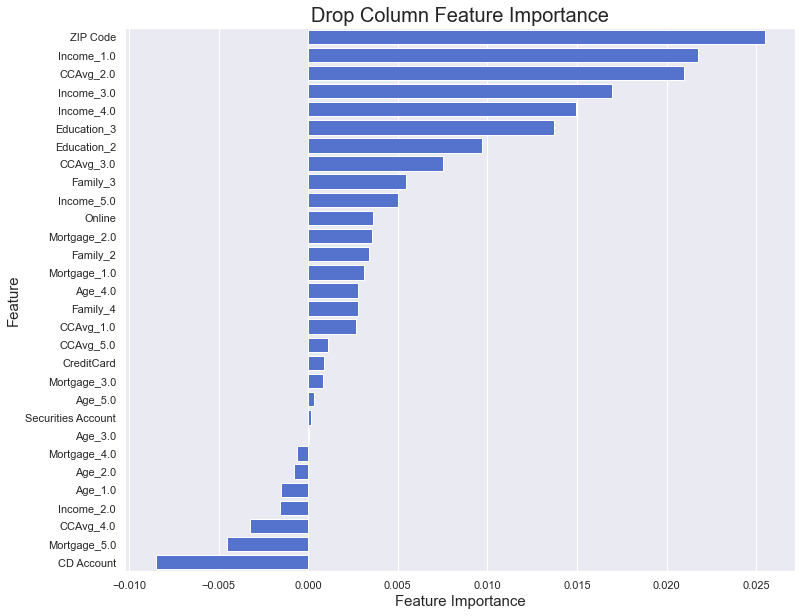

In [34]:
# Initialize the CNB classifier
cnb = ComplementNB()

# Call drop_column_importance_plot
drop_column_importance_plot(cnb, X_train, y_train)

Cuando se habla de importancia negativa en la función de importancia de eliminación de columnas, significa que al eliminar la característica correspondiente del modelo, en realidad se mejora el rendimiento del modelo. Por lo tanto, filtramos nuestro conjunto de datos:

In [35]:
feature_importances = drop_column_importance(cnb, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filtro al  dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

#### <font color='royalblue'> 9.1.4: Modelo de Complemento Naive Bayes (CNB) </font>

Después de eliminar las características irrelevantes, entrenamos el modelo CNB final:

In [36]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)

ComplementNB()

<font color='royalblue'> Pasos 9.1.5: Evaluación del Modelo Complementario de Naive Bayes </font>

Para evaluar el rendimiento del modelo, definimos una función que también se puede utilizar para evaluar modelos posteriores:

In [37]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    Esta función calcula todas las métricas de rendimiento deseadas para un modelo dado en los datos de prueba
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [38]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
Esta función proporciona un informe completo del rendimiento del modelo, que incluye informes de clasificación, matriz de confusión y curva ROC
    '''
    sns.set(font_scale=1.2)

    # Generamos el informe de clasificación para el conjunto de entrenamiento
    y_pred_train = clf.predict(X_train)
    print("\n\t  Informe de clasificación para el conjunto de entrenamiento.")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generamos el informe de clasificación para el conjunto de prueba
    y_pred_test = clf.predict(X_test)
    print("\n\t   Informe de clasificación para el conjunto de prueba")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))

    # Creamos
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})

    # Generar la matriz de confusión para el conjunto de prueba
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Gráfico de la curva ROC para los datos de prueba y muestra el puntaje AUC
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')

    # Presenta los resultados para la clase especificada por la etiqueta positiva
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modificamos el color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()

Llamemos a la función anterior para evaluar nuestro modelo CNB:






	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3570
           1       0.39      0.91      0.55       346

    accuracy                           0.87      3916
   macro avg       0.69      0.89      0.74      3916
weighted avg       0.94      0.87      0.89      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       892
           1       0.38      0.91      0.54        87

    accuracy                           0.86       979
   macro avg       0.69      0.88      0.73       979
weighted avg       0.94      0.86      0.89       979



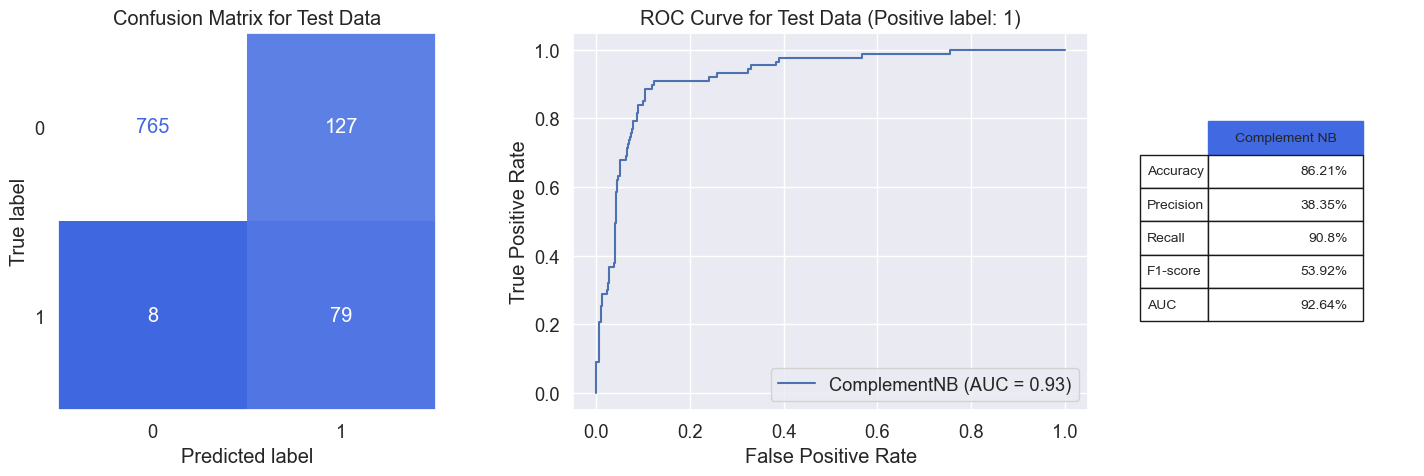

In [39]:
model_evaluation(cnb, X_train, X_test, y_train, y_test, 'Complement NB')

Obtuvimos un puntaje de recuperación (recall) de aproximadamente el 90% con el modelo Complementario de Naive Bayes, lo cual es bueno. Sin embargo, debido al valor de precisión bajo del 38%, el puntaje F1 es de aproximadamente el 53%

In [40]:
# Guardamos el rendimiento final del clasificador Complement Naive Bayes.
cnb_result = metrics_calculator(cnb, X_test, y_test, 'Complement Naive Bayes')

####  <font color='royalblue'> Pasos 9.2: Construcción del modelo Bernoulli NB. </font>

**Bernoulli NB**, al igual que MultinomialNB, es adecuado para datos discretos. La diferencia radica en que mientras MultinomialNB trabaja con recuentos de ocurrencias, BernoulliNB está diseñado para trabajar con datos binarios, donde las características son verdaderas o falsas (1 o 0)

#### <font color='royalblue'> Pasos 9.2.1: Discretización de características en Bernoulli NB </font>
Para encontrar los valores óptimos para KBinsDiscretizer considerando Bernoulli NB, llamamos a la función discretization_report:

In [43]:
# Inicamos el Clasificador Categorical NB 
bnb = BernoulliNB()

# Llamamos discretization_report
n_bins, strategy = discretization_report(df, bnb)

Best discretization parameters: {'discretizer__n_bins': 4, 'discretizer__strategy': 'quantile'}
Best score: 0.5123297006257326


Los valores óptimos obtenidos para n_bins y strategy considerando el modelo BNB son:

* **n_bins:** 9
* **strategy:** uniforme (todos los intervalos en cada característica tienen anchos idénticos)

#### <font color='royalblue'> Pasos 9.2.2: Codificación de características para Bernoulli NB </font>

Ahora, discretizamos las características continuas con los valores óptimos obtenidos para n_bins y strategy. Luego, necesitamos aplicar codificación de variables ficticias a todas las características no binarias.

Dado que la característica del código postal contiene una gran cantidad de categorías y no es una característica importante, la eliminaremos para el modelado de Bernoulli NB:

In [44]:
df_bnb = df.copy()
df_bnb.drop('ZIP Code', axis=1, inplace=True)

Aplicando codificación one-hot a todas las características no binarias utilizando la función nb_feature_encoding:

In [45]:
# Se eligen todas las caracvariables no binarias para la codificación one-hot.
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

# Llamamos nb_feature_encoding
X_train, X_test = nb_feature_encoding(df_bnb, n_bins, strategy, cols_to_encode)

#### <font color='royalblue'> Pasos 9.2.3: Selección de subconjunto de características Bernoulli NB </font>

Para encontrar las características más importantes considerando el modelo BNB, nuevamente utilizamos la función drop_column_importance_plot que definimos anteriormente:

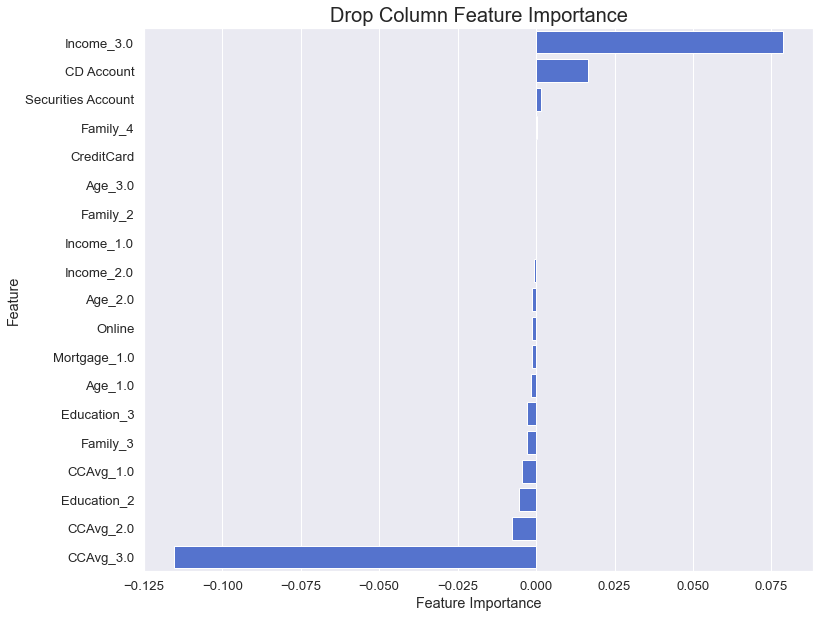

In [46]:
# Iniciamos el Clasificados BNB
bnb = BernoulliNB()

# Llamamos drop_column_importance_plot
drop_column_importance_plot(bnb, X_train, y_train)

Nuevamente, la importancia negativa en la función de importancia de características al eliminar columnas significa que al quitar la característica correspondiente del modelo, realmente mejora el rendimiento del modelo. Por lo tanto, filtramos nuestro conjunto de datos

In [47]:
# Identificamos las características relevantes con valores de importancia positivos
feature_importances = drop_column_importance(bnb, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filtramos dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

#### <font color='royalblue'> Pasos 9.2.4: Construcción del Modelo Bernoulli NB </font>

After removing irrelevant features, we train the final BNB model:

In [48]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

#### <font color='royalblue'> Pasos 9.2.5: Evaluación del Modelo Bernoulli NB </font>

Evaluar el rendimiento de nuestro modelo Bernoulli NB entrenado utilizando la función model_evaluation:


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3570
           1       0.76      0.26      0.39       346

    accuracy                           0.93      3916
   macro avg       0.85      0.63      0.68      3916
weighted avg       0.92      0.93      0.91      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       892
           1       0.78      0.24      0.37        87

    accuracy                           0.93       979
   macro avg       0.85      0.62      0.66       979
weighted avg       0.92      0.93      0.91       979



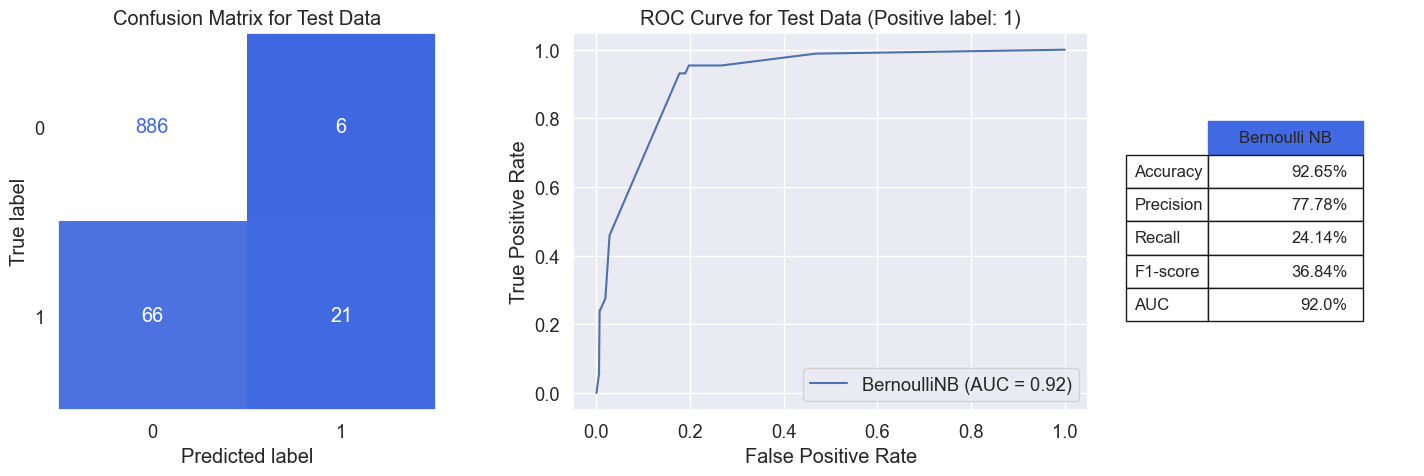

In [49]:
model_evaluation(bnb, X_train, X_test, y_train, y_test, 'Bernoulli NB')

Obtuvimos una disminución del 17% en el puntaje F1 en comparación con el modelo Complement NB. En el modelo Bernoulli NB, en comparación con el Complement NB, el valor de precisión ha aumentado, mientras que el valor de recuperación (recall) ha disminuido. El valor del área bajo la curva (AUC) casi no difirió

In [50]:
# Guardamos el rendimiento final del clasificador de Naive Bayes Bernoulli
bnb_result = metrics_calculator(bnb, X_test, y_test, 'Bernoulli Naive Bayes')

### <font color='royalblue'> Paso 10: Construcción del Modelo de Regresión Logística </font>

**La Regresión Logística** es un algoritmo de aprendizaje automático supervisado utilizado principalmente para problemas de clasificación binaria. Modela la probabilidad de una variable objetivo (generalmente binaria) como una función de las características de entrada, utilizando una función logística (sigmoide) para mapear las predicciones entre 0 y 1. El modelo se entrena utilizando datos etiquetados para optimizar los coeficientes de las características y minimizar el error de predicción. 

#### <font color='royalblue'> Paso 10.1: Escalar datos usando el escalador estándar </font>

Antes de construir nuestro clasificador logístico, aplicaremos el escalador estándar a nuestros datos. <br>

El **escalador estándar** se utiliza para escalar los datos. Transforma los datos restando la media y dividiendo por la desviación estándar, asegurando que todas las características tengan un rango de valores similar.

**Beneficios del escalado estándar en la regresión logística:**


1. **Convergencia del descenso de gradiente:** El algoritmo de optimización utilizado en la regresión logística es el descenso de gradiente. Cuando las características tienen diferentes escalas, la magnitud del gradiente también será diferente para diferentes características. Escalar las características para que tengan la misma escala garantiza que la magnitud del gradiente sea la misma para todas las características, lo que puede llevar a una convergencia más rápida del algoritmo de optimización.

2. **Regularización:** La regresión logística utiliza la regularización para prevenir el sobreajuste. Cuando las características tienen diferentes escalas, el término de regularización en la función de costo tiende a dar más peso a las características con valores más altos, lo que puede ser problemático en ciertos casos. Escalar las características para que tengan la misma escala puede aliviar este problema.

3. **Mejor rendimiento:** En algunos casos, el escalado de las características puede mejorar el rendimiento del modelo de regresión logística, especialmente cuando las características tienen una distribución sesgada o no están en la misma escala 

In [51]:
# Realizamos la división entre datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [52]:
# Estandarizamos los datos de entrenamiento y prueba utilizando el mismo escalador.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos el conjunto de datos de entrenamiento y prueba desde Numpy array a dataframes Pandas
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### <font color='royalblue'> Paso 10.2: Ajuste de hiperparámetros para la regresión logística </font>

La **sintonización de hiperparámetros** puede afectar el rendimiento de un modelo de regresión logística al permitirle encontrar la mejor combinación de hiperparámetros que resulte en el error más bajo en el conjunto de entrenamiento. Esto puede conducir a un mejor rendimiento de predicción y a una reducción del sobreajuste. Sin embargo, si no se realiza correctamente, puede provocar sobreajuste en el conjunto de validación, lo que resulta en un modelo que no es generalizable a nuevos datos.

Además, dado que nuestro conjunto de datos está desequilibrado, tenemos la intención de darle más importancia a la clasificación correcta de la clase minoritaria que a la clasificación correcta de la clase mayoritaria en el proceso de optimización, lo que se conoce como **penalización** del modelo. Hacemos esto otorgando más peso a la clase minoritaria. Por lo tanto, los pesos de las clases son hiperparámetros cuyo valor óptimo también se determina durante el proceso de sintonización de hiperparámetros.


Paso 10.2.1, definimos el hiperparámetro Grid

* **lbfgs -> [ l2 , None ]**
* **liblinear -> [ l1 , l2 ]**
* **newton-cg -> [ l2 , None ]**
* **sag -> [ l2 , None ]**
* **saga -> [ elasticnet , l1 , l2 , None ]**

Por lo tanto, se deben considerar diferentes combinaciones de solucionadores y penalizaciones:




In [53]:
# Ponderaciones Asociadas a las clases
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,20)]

# Definimos el conjunto de hiperparámetros
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
               'penalty':['none'],
               'class_weight':class_weights},

              {'solver':['lbfgs', 'newton-cg', 'sag'],
               'penalty':['l2'],
               'C': np.logspace(-5, 5, 10),
               'class_weight':class_weights},

              {'solver':['liblinear', 'saga'],
               'penalty': ['l1', 'l2'],
               'C': np.logspace(-5, 5, 10),
               'class_weight':class_weights},

              {'solver':['saga'],
               'penalty':['elasticnet'],
               'C': np.logspace(-5, 5, 10),
               'l1_ratio': np.arange(0,1.1,0.1),
               'class_weight':class_weights}]

#### <font color='royalblue'> En el Paso 10.2.2, se busca encontrar los hiperparámetros óptimos. </font>

Utilizamos GridSearchCV para encontrar la combinación óptima de hiperparámetros que brinda el mejor rendimiento en los datos de entrenamiento:

Definiremos una función en la cual se descubrirá la combinación óptima de hiperparámetros que generará el mejor valor de f1-score para el modelo. Por esta razón, definimos una función que también se puede utilizar para ajustar los hiperparámetros de modelos futuros.

In [54]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    '''
Esta función optimiza los hiperparámetros de un clasificador mediante
    la búsqueda en una rejilla de hiperparámetros especificada.
    Utiliza GridSearchCV y validación cruzada (StratifiedKFold) para evaluar
    diferentes combinaciones de hiperparámetros y selecciona la combinación con el mayor puntaje F1.
    La función devuelve el mejor clasificador con los hiperparámetros óptimos
    '''

    # creamos el objeto de validación cruzada utilizando StratifiedKFold y asegurar que la distribución de clases sea la misma en todos los pliegues
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Creamos el Objeto GridSearchCV
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_metric, n_jobs=-1)

    # Ajustamos el objeto GridSearchCV con los datos de entrenamiento
    clf_grid.fit(X_train, y_train)

    # Obtenemos los mejores hiperparámetros
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Produce best_estimator_ attribute esto nos proporciona el mejor modelo que se ha ajustado a los datos de entrenamiento
    return clf_grid.best_estimator_

Utilizamos la función anterior para encontrar la combinación óptima de hiperparámetros para el clasificador de regresión logística. 

In [55]:
# Definimos el Modelo Base
logreg = LogisticRegression(max_iter=1000)

# Llamamos tune_clf_hyperparameters función que busca la mejor combinación de hiperparámetros
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 3.593813663804626, 'class_weight': {0: 0.5, 1: 0.5}, 'penalty': 'l1', 'solver': 'liblinear'}


Estos son los valores óptimos de los hiperparámetros para el modelo de Regresión Logísticalogreg_opt es el modelo de Regresión Logística cuyos hiperparámetros se han ajustado a los valores óptimos. 

### <font color='royalblue'> Paso 10.3: Selección de Subconjuntos de Características para Regresión Logística </font>

Vamos a verificar cuán importantes son cada una de las características para nuestro modelo de regresión logística. Utilizamos la función drop_column_importance_plot que definimos anteriormente.

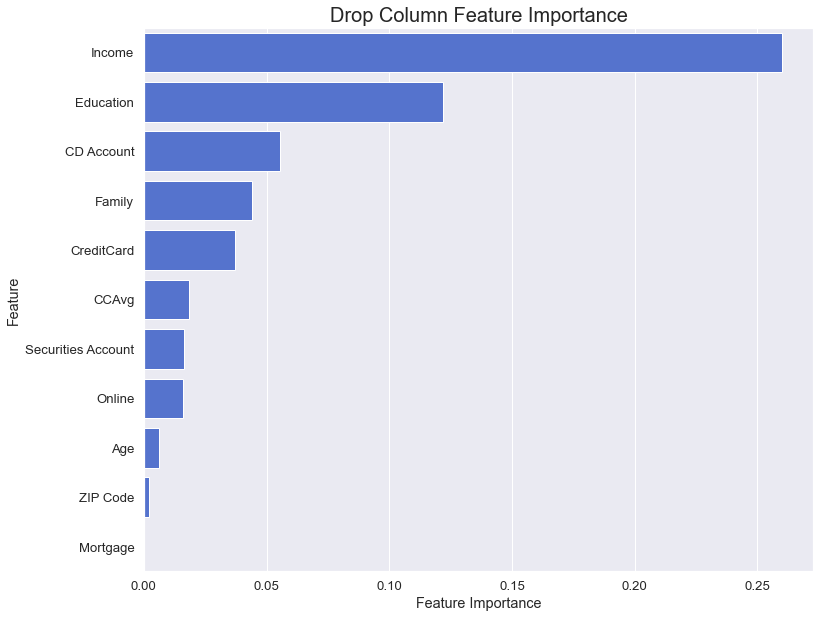

In [56]:
drop_column_importance_plot(logreg_opt, X_train, y_train)

Casi no se observan valores negativos entre las Importancias de las Características al Eliminar Columnas. En otras palabras, todas las características son efectivas en la estimación del objetivo

### <font color='royalblue'> Paso 10.4: Evaluación del Modelo de Regresión Logística </font>

Vamos a evaluar el rendimiento del modelo de Regresión Logística utilizando la función model_evaluation:


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3570
           1       0.84      0.63      0.72       346

    accuracy                           0.96      3916
   macro avg       0.90      0.81      0.85      3916
weighted avg       0.95      0.96      0.95      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       892
           1       0.78      0.59      0.67        87

    accuracy                           0.95       979
   macro avg       0.87      0.79      0.82       979
weighted avg       0.94      0.95      0.95       979



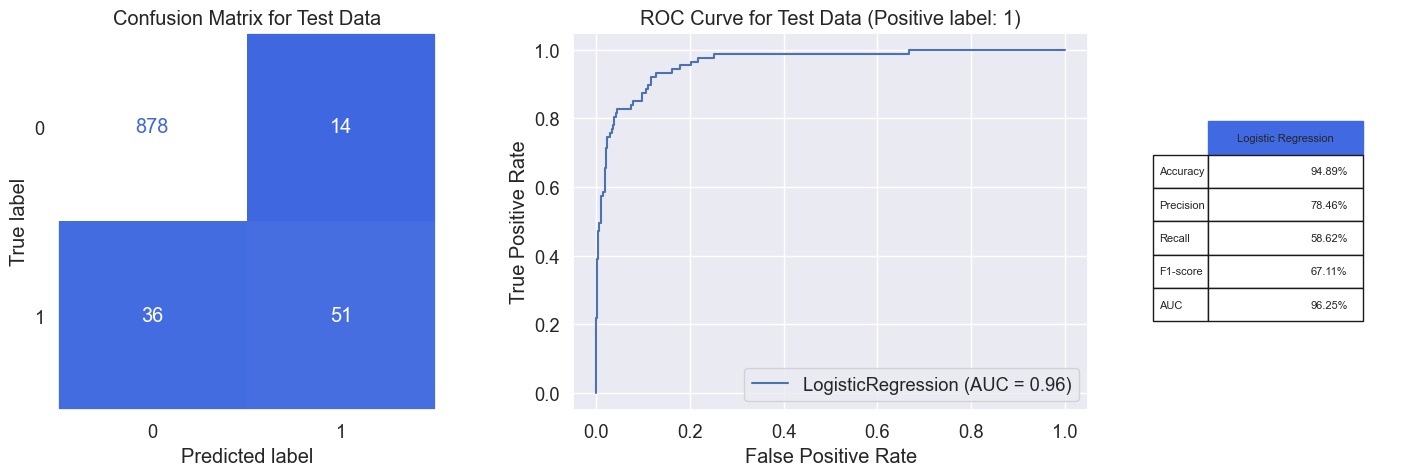

In [57]:
model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')

Se observa un aumento del 31% en el puntaje F1 del modelo logístico en comparación con el modelo NB Bernoulli, lo cual es interesante.

In [58]:
# Guardamos el rendimiento final del clasificador de Regresión Logística
logreg_result = metrics_calculator(logreg_opt, X_test, y_test, 'Logistic Regression')

### <font color='royalblue'>  Paso 11: Construcción del Modelo KNN </font>

**KNN (K-Nearest Neighbors)** es un algoritmo de aprendizaje supervisado utilizado para problemas de clasificación y regresión en el campo del aprendizaje automático. El algoritmo funciona encontrando los K puntos de datos más cercanos a una muestra de prueba dada y, a continuación, clasificando la muestra de prueba en función de la clase mayoritaria entre los K vecinos más cercanos. Para determinar los vecinos más cercanos, el algoritmo utiliza una métrica de distancia (como la distancia euclidiana). El valor de K es un hiperparámetro que determina la cantidad de vecinos utilizados para realizar la predicción. <br>

**Ventajas:**

* Fácil de implementar y entender: El algoritmo KNN es sencillo y fácil de comprender, lo que lo convierte en una opción popular para principiantes en el campo del aprendizaje automático.
* No requiere entrenamiento: El KNN no necesita un proceso de entrenamiento previo, lo que significa que se puede utilizar en aplicaciones en tiempo real donde los datos se generan continuamente.
* Puede manejar grandes conjuntos de datos: El KNN puede manejar grandes conjuntos de datos sin sufrir el problema de la maldición de la dimensionalidad, que es común en otros algoritmos de aprendizaje automático.
* Preciso y efectivo: El KNN es conocido por su precisión y efectividad, especialmente cuando se utiliza con conjuntos de datos pequeños o medianos. Es un algoritmo robusto que puede manejar datos ruidosos e incompletos, lo que lo convierte en una opción popular en muchas aplicaciones del mundo real. <br>

**Desventajas:**

* Sensible a los valores atípicos: El KNN puede ser sensible a los valores atípicos en los datos, lo que puede afectar significativamente su rendimiento.
* Costoso computacionalmente: El cálculo de las distancias entre cada punto de datos de prueba y todos los puntos de datos de entrenamiento puede ser costoso computacionalmente, especialmente para conjuntos de datos grandes.
* No funciona bien con datos de alta dimensionalidad: La métrica de distancia se vuelve menos efectiva en espacios de alta dimensión.
* Puede estar sesgado hacia la clase mayoritaria: Si la mayoría de los vecinos son de una clase específica, el KNN puede estar sesgado hacia esa clase.
* Sensible a características irrelevantes y datos ruidosos: Es importante realizar una selección adecuada de características para evitar que características irrelevantes afecten el rendimiento del algoritmo

### <font color='royalblue'> Paso 11.1: Escalar datos usando el Estándar Scaler </font>

Como KNN (K-Nearest Neighbors) utiliza una métrica de distancia para encontrar sus vecinos más cercanos, es necesario aplicar el escalado estándar (normalización) para reajustar las características de manera que tengan la misma escala. Las características con diferentes escalas y distribuciones pueden afectar el cálculo de distancias y, por ende, el rendimiento del algoritmo. 

In [59]:
# Realizamos la partición de datos entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [60]:
# Aplicamos la misma técnica de escalado a los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transformamos los conjuntos de entrenamiento y prueba desde matrices numpy a dataframes de pandas
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### <font color='royalblue'> Paso 11.2: Ajuste de hiperparámetros del KNN </font>

* **n_neighbors:** Este es el número de vecinos más cercanos que se utilizarán para predecir la clase de una nueva muestra.
* **weights:** Esto determina cómo se ponderan las distancias entre las muestras al realizar predicciones.
> * uniform - Todos los vecinos se ponderan por igual. <br>
> * distance - Los vecinos más cercanos a la muestra tienen más peso. 

* **metric:** Esta es la métrica de distancia utilizada para determinar los vecinos más cercanos. Las opciones son:
> * euclidean <br>
> * manhattan <br>
> * minkowski (the generalization of both distances) <br>

* El **parámetro p** es utilizado en la métrica de Minkowski. Cuando p=1, la métrica de Minkowski es equivalente a la distancia de Manhattan; cuando p=2, es equivalente a la distancia Euclidiana. Un valor de p diferente de 1 o 2 puede utilizarse para ponderar de manera diferente la contribución de las distancias entre coordenadas. 


Necesitamos ajustar los valores de los hiperparámetros para nuestro clasificador k-vecinos más cercanos (k-NN). Para este propósito, primero definimos nuestra grid de hiperparámetros y luego llamamos a la función tune_clf_hyperparameters para encontrar la mejor combinación de hiperparámetros.


In [61]:
# Defimos los el conjunto de hiperparámetros a buscar
param_grid = [{'n_neighbors': np.arange(2, 30), 'metric': ['euclidean','manhattan'], 'weights': ['uniform']},
              {'n_neighbors': np.arange(2, 30), 'metric': ['minkowski'], 'p': [3,4,5], 'weights': ['uniform']}]

Vamos a llamar a la función tune_clf_hyperparameters para la calibración de hiperparámetros:

In [63]:
# Creamos el objeto clasificador KNN
knn = KNeighborsClassifier()

# Buscamos el mejor clasificador con los hiperparámetros óptimos
knn_opt = tune_clf_hyperparameters(knn, param_grid, X_train, y_train)

Best hyperparameters:
 {'metric': 'minkowski', 'n_neighbors': 3, 'p': 5, 'weights': 'uniform'}


### <font color='royalblue'> Paso 11.3: Selección de subconjunto de características KNN </font>


Los clasificadores KNN son sensibles a las características irrelevantes porque miden las distancias entre instancias y ponderan cada característica por igual en el cálculo de la distancia. Esto significa que una característica con un alto nivel de aleatoriedad o ruido puede tener una gran influencia en las distancias calculadas, lo que resulta en predicciones inexactas:

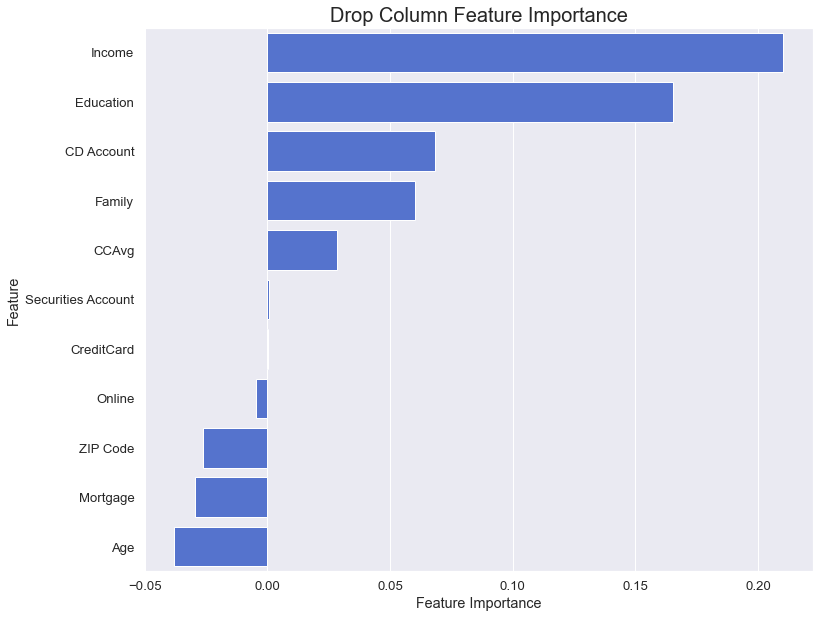

In [329]:
drop_column_importance_plot(knn_opt, X_train, y_train)

En los resultados de importancia de características al eliminar columnas, se observan varias características con importancia negativa. La eliminación de estas características mejora el rendimiento del modelo. Una de estas características con el valor de importancia más negativo es el código postal, que ya habíamos identificado en el paso 3, como una característica no relevante debido a su gran cantidad de categorías. Filtramos nuestro conjunto de datos:

In [64]:
# Encuentramos las características importantes con un valor feature_importance positivo
feature_importances = drop_column_importance(knn_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filtramos el dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Vamos a ajustar los hiperparámetros de nuestro modelo nuevamente después de eliminar las características irrelevantes.

In [65]:
# Creamos el objeto clasificador KNN classifier
knn = KNeighborsClassifier()

# Buscamos el mejor clasificador con los hiperparámetros optimos
knn_opt = tune_clf_hyperparameters(knn, param_grid, X_train, y_train)

Best hyperparameters:
 {'metric': 'minkowski', 'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}


### <font color='royalblue'> Paso 11.4: Evaluar el Modelo KNN  </font>

Vamos a evaluar el rendimiento del modelo KNN utilizando la función de evaluación del modelo:



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3570
           1       0.99      0.87      0.92       346

    accuracy                           0.99      3916
   macro avg       0.99      0.93      0.96      3916
weighted avg       0.99      0.99      0.99      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       892
           1       0.92      0.78      0.84        87

    accuracy                           0.97       979
   macro avg       0.95      0.89      0.92       979
weighted avg       0.97      0.97      0.97       979



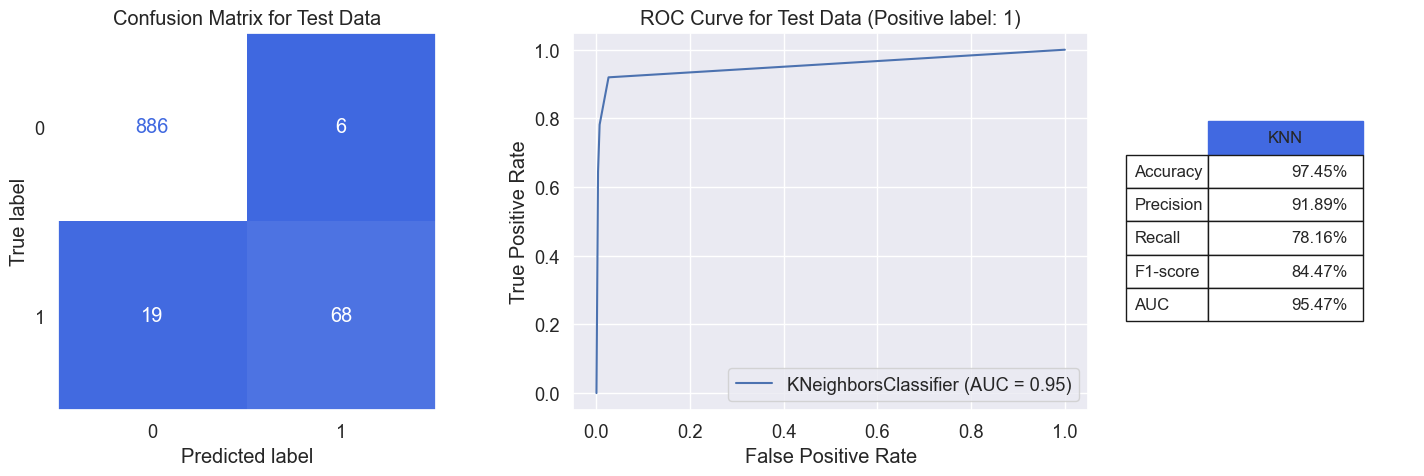

In [332]:
model_evaluation(knn_opt, X_train, X_test, y_train, y_test, 'KNN')

¡Obtuvimos un notable 84.47 % de puntuación F1, 91% de precisión y 78% de recuperación utilizando el clasificador KNN simple!

In [66]:
# Guardamos el rendimiento final del clasificador del clasificador KNN
knn_result = metrics_calculator(knn_opt, X_test, y_test, 'K-Nearest Neighbors')

## <font color='royalblue'> Paso 12: Construcción del Modelo SVM </font>

**Support Vector Machine (SVM)** es un tipo de algoritmo de aprendizaje supervisado que se utiliza para tareas de clasificación o regresión. Funciona encontrando el mejor límite (también conocido como límite de decisión) que separa los puntos de datos en clases, al tiempo que maximiza el margen (la distancia entre el límite y los puntos de datos más cercanos de cada clase, conocidos como vectores de soporte). SVM puede manejar datos no linealmente separables al transformarlos en un espacio de mayor dimensión, donde se vuelven linealmente separables 

Ventajas:

* **Robusto ante valores atípicos:** SVM es menos sensible a los valores atípicos en comparación con otros algoritmos, lo que lo hace adecuado para tareas donde se espera la presencia de valores atípicos.
* **Versátil:** SVM se puede utilizar para tareas de clasificación y regresión, así como para manejar datos no lineales mediante el uso de funciones de kernel.
* **Efectivo en espacios de alta dimensión:** SVM es eficaz en espacios de mayor dimensión, donde el número de características es mayor que el número de muestras.
* **Buen rendimiento en conjuntos de datos más pequeños:** SVM tiene un buen rendimiento incluso en conjuntos de datos más pequeños y no requiere una gran cantidad de datos de entrenamiento para producir resultados precisos.

Disadvantages:

* **Rendimiento deficiente en conjuntos de datos grandes:** SVM puede ser intensivo en términos de cómputo y volverse lento cuando el conjunto de datos es grande.
* **Sobreajuste:** SVM puede sobreajustar los datos, especialmente cuando el número de características es mucho mayor que el número de muestras.
* **Interpretación limitada:** SVM es un modelo de caja negra y puede ser difícil interpretar los resultados y comprender cómo el algoritmo realiza predicciones.
* **Dificultad para elegir la función de kernel adecuada:** La elección de la función de kernel es crucial para el rendimiento de SVM y puede ser complicado determinar la mejor para un problema específico.


### <font color='royalblue'> Paso 12.1: Escalar datos usando el escalador estándar </font>

SVM (Support Vector Machine) es un clasificador basado en distancias. SVM funciona encontrando el límite que mejor separa los datos en clases, al tiempo que maximiza el margen (la distancia entre el límite y los puntos de datos más cercanos de cada clase, conocidos como vectores de soporte). Esto significa que SVM se basa en el concepto de distancia y busca encontrar el límite óptimo que maximice la distancia entre las clases. Por lo tanto, debe realizarse una estandarización de escala antes de construir el modelo:

In [334]:
# Realizamos la división de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [335]:
# Escalamos los datos de entrenamiento y prueba utilizando el mismo escalador
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transformamos los conjuntos de entrenamiento y prueba desde matrices numpy a dataframes de pandas
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

###  <font color='royalblue'> Paso 12.2: Ajuste de Hiperparámetros de SVM </font>

Los hiperparámetros del clasificador SVM (Support Vector Machine) son los siguientes:
> * **C**: Este hiperparámetro controla el equilibrio entre lograr un bajo error de entrenamiento y un bajo error de prueba. Un valor más pequeño de C resulta en un margen más amplio y un mayor número de ejemplos de entrenamiento mal clasificados, mientras que un valor más grande de C resulta en un margen más estrecho y menos ejemplos de entrenamiento mal clasificados.
> * **kernel**: Este hiperparámetro define el tipo de función de kernel utilizada para transformar los datos de entrada en un espacio dimensional superior donde se puede encontrar un límite lineal. Las funciones de kernel comunes incluyen el kernel lineal, polinomial, rbf (función de base radial), sigmoidal y precalculado.
> * **gamma**: Coeficiente del kernel para los kernels rbf, polinomial y sigmoidal.
> * **degree**: Este hiperparámetro solo es relevante cuando se utiliza el kernel polinomial. Define el grado de la función polinomial utilizada para transformar los datos de entrada.

El rendimiento de un clasificador SVM (Support Vector Machine) puede verse fuertemente afectado por la elección de los hiperparámetros, y encontrar los hiperparámetros óptimos puede ayudar a mejorar el rendimiento del clasificador. Por lo tanto, nuevamente definimos una rejilla de hiperparámetros para la búsqueda y luego llamamos a la función tune_clf_hyperparameters para encontrar los valores óptimos de los hiperparámetros de SVM que mejor se ajusten a nuestros datos:

In [67]:
# Pesos asociados a las clases
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,12)]

# Definimos el conjunto de hiperparámetros a buscar
param_grid = [{'kernel': ['poly'], 
               'degree': [2,3,4,5], 
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights},
                  
              {'kernel': ['rbf','sigmoid'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights},
                  
              {'kernel': ['linear'],
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights}
             ]

Tuning hyperparameters for Support Vector Machines (SVM) can be time-consuming as it involves training the model multiple times with different hyperparameter values and evaluating their performance to find the optimal set of hyperparameters. After tuning SVM hyperparameters once, we found that the rbf kernel is the optimal kernel for this dataset. Therefore, we limit our param_grid to the rbf kernel to reduce the program's run time:

In [68]:
# Ponderaciones asociados a las clases
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,12)]

# Definimos el conjunto de hiperparámetros a buscar
param_grid = [{'kernel': ['rbf'],
               'gamma': [0.1, 0.01, 0.001, 0.0001], 
               'C': [0.1, 1, 10, 100, 1000],
               'class_weight': class_weights}] 

Vamos a llamar a la función tune_clf_hyperparameters para la sintonización de hiperparámetros:

In [69]:
# Creamos el objecto SVM
svm = SVC(probability=True, random_state=0)

# Buscamos el mejor clasificador con los hiperparámetros óptimos
svm_opt = tune_clf_hyperparameters(svm, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 1000, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 0.1, 'kernel': 'rbf'}


### <font color='royalblue'> Step 12.3: SVM Feature Subset Selection </font>

Los clasificadores SVM pueden ser sensibles a características irrelevantes. Si los datos de entrada contienen características irrelevantes, estas pueden afectar negativamente el rendimiento del clasificador SVM. Esto se debe a que el algoritmo SVM considera todas las características por igual al encontrar el límite de decisión, y las características irrelevantes pueden distraer al algoritmo de encontrar el límite que separa las clases de manera efectiva.

Para evitar este problema, se recomienda realizar una selección de características antes de entrenar un clasificador SVM, lo que implica eliminar cualquier característica irrelevante o redundante de los datos de entrada. Esto puede mejorar el rendimiento del clasificador SVM al reducir la complejidad del problema y permitir que el algoritmo se enfoque en las características más relevantes.


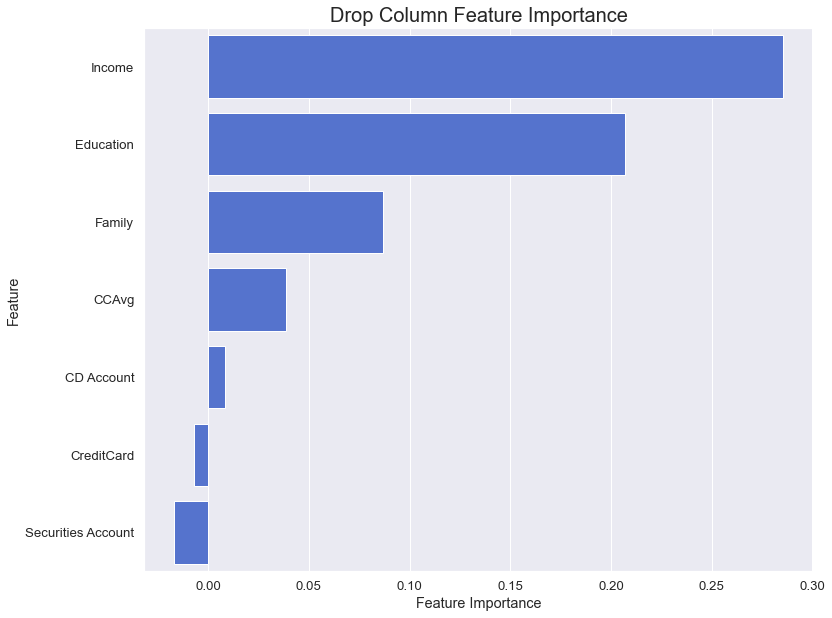

In [70]:
drop_column_importance_plot(svm_opt, X_train, y_train)

En los resultados de importancia de características al eliminar columnas, se observan varias características con importancia negativa. La eliminación de estas características mejora el rendimiento del modelo. Vamos a filtrar nuestro conjunto de datos:

In [71]:
# Buscamos características importantes con un valor de feature_importance positivo
feature_importances = drop_column_importance(svm_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filtramos el dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Vamos a ajustar los hiperparámetros de nuestro modelo nuevamente después de eliminar las características irrelevantes:

In [72]:
# Creamos el objeto SVC
svm = SVC(probability=True, random_state=0)

# Buscamos el mejor clasificador con los hiperparámetros óptimos
svm_opt = tune_clf_hyperparameters(svm, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 1000, 'class_weight': {0: 0.4092727272727273, 1: 0.5907272727272728}, 'gamma': 0.1, 'kernel': 'rbf'}


### <font color='royalblue'> Paso 12.4: Evaluación del Modelo SVM </font>

Vamos a evaluar el rendimiento del modelo SVM utilizando la función de evaluación del modelo:



	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3570
           1       0.96      0.91      0.93       346

    accuracy                           0.99      3916
   macro avg       0.97      0.95      0.96      3916
weighted avg       0.99      0.99      0.99      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.91      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



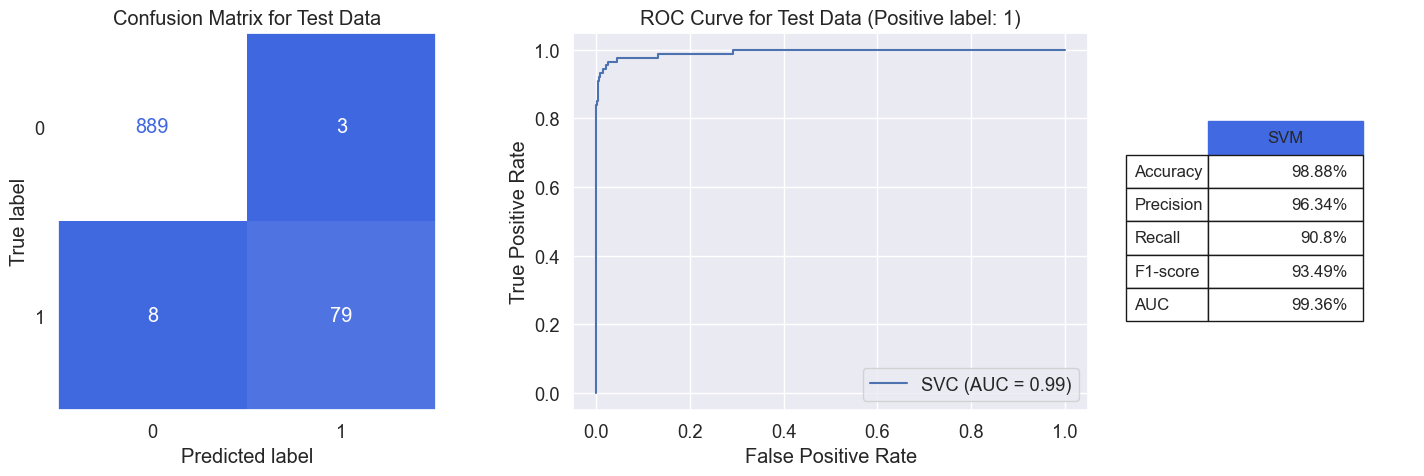

In [73]:
model_evaluation(svm_opt, X_train, X_test, y_train, y_test, 'SVM')

Hemos logrado mejorar el puntaje F1 para nuestro modelo SVM en comparación con el modelo KNN, pero, por otro lado, el valor del Área bajo la Curva (AUC) ha mejorado a 0.98. 

In [74]:
# Guardamos el rendimiento final del clasificador SVM 
svm_result = metrics_calculator(svm_opt, X_test, y_test, 'SVM')

### <font color='royalblue'> Paso 13: Construcción del Modelo de Árbol de Decisiones </font>

Un Árbol de Decisión es un algoritmo de aprendizaje supervisado basado en árboles que se puede utilizar para tareas de clasificación o regresión. Funciona dividiendo recursivamente los datos en subconjuntos según los valores de las características, con el objetivo de minimizar una función de costo, como la impureza de Gini o la entropía .

Ventajas: <br>

* **Fácil de entender e interpretar:** Los Árboles de Decisión son sencillos de comprender y visualizar.
* **Manejo de datos numéricos y categóricos:** Los Árboles de Decisión pueden trabajar con datos tanto numéricos como categóricos.
* **Selección de características:** Se pueden utilizar para seleccionar características importantes, ya que estas suelen aparecer cerca de la raíz del árbol.
* **No paramétricos:** Los Árboles de Decisión no hacen suposiciones sobre la distribución subyacente de los datos.

Desventajas:

* **Sobreajuste:** Los Árboles de Decisión pueden ser propensos al sobreajuste, especialmente cuando son profundos o se utilizan conjuntos de entrenamiento pequeños. Esto puede resultar en una mala generalización a nuevos datos
* **Inestabilidad:** Pequeños cambios en los datos pueden generar grandes variaciones en el árbol, lo que los hace inestables.
* **Bias towards features with many categories:** Los Árboles de Decisión pueden estar sesgados hacia características con muchas categorías, ya que estas pueden dominar la construcción del árbol. 
* **Aproximación deficiente de funciones complejas:** Los Árboles de Decisión pueden no ser adecuados para aproximar funciones complejas, ya que están limitados por las divisiones paralelas a los ejes en cada nodo.

**Nota:** Los Árboles de Decisión no requieren escalado estándar de los datos antes de construir el modelo. El escalado estándar se utiliza típicamente para algoritmos que son sensibles a la escala de las características de entrada, como los algoritmos basados en distancias como KNN y SVM.




###  <font color='royalblue'> 13.1: Ajuste de Hiperparámetros para Árboles de Decisión </font>
Los clasificadores de árboles de decisión son propensos al sobreajuste. Esto ocurre cuando el árbol es demasiado complejo y se ajusta demasiado a los datos de entrenamiento, capturando incluso el ruido presente en los datos. <br>

Maneras de prevenir el sobreajuste en los clasificadores de árboles de decisión:
> **Poda:** Eliminar ramas del árbol que no contribuyen significativamente a la clasificación. <br>
> **Uso de métodos de conjunto:** Combinar múltiples árboles de decisión para obtener un modelo más robusto. <br>
> **Limitar el tamaño del árbol:** Establecer un número mínimo de muestras requeridas para dividir un nodo interno o una profundidad máxima para el árbol.

Los siguientes son los hiperparámetros más comunes para los clasificadores de árboles de decisión:

> **Criterio:** Este hiperparámetro determina el criterio utilizado para medir la calidad de una división. Los criterios comúnmente utilizados son “Impureza de Gini” y “Ganancia de Información”. <br>
> **Profundidad máxima:** Este hiperparámetro controla la profundidad máxima del árbol. Cuanto más profundo sea el árbol, más complejo se vuelve, lo que puede provocar sobreajuste. Establecer una profundidad máxima puede prevenir el sobreajuste al limitar el tamaño del árbol. <br>
> **Muestras mínimas por división:** Este hiperparámetro establece el número mínimo de muestras requeridas para dividir un nodo interno. Si el número de muestras en un nodo es menor que este valor, el nodo no puede dividirse aún más. Esto también puede prevenir el sobreajuste al limitar el tamaño del árbol.<br>
> **Muestras mínimas por hoja:** Este hiperparámetro establece el número mínimo de muestras requeridas para un nodo hoja. Si un nodo hoja tiene menos muestras que este valor, puede ser eliminado.<br>
> **Características máximas:** Este hiperparámetro determina el número máximo de características a considerar al dividir un nodo. Se utiliza para prevenir el sobreajuste al reducir la complejidad del modelo.<br>
> **Peso de Clase:** Pesos asociados con las clases.

Nuevamente definimos nuestro grid de hiperparámetros utilizando los hiperparámetros mencionados anteriormente y luego llamamos a la función tune_clf_hyperparameters para encontrar la mejor combinación

In [75]:
# Ponderaciones asociadas a las clases
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]
    
# Definimos el conjunto de hiperparámetros a buscar
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 10),
              'min_samples_split': np.arange(1, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2'],
              'class_weight': class_weights} 

Vamos a llamar a la función tune_clf_hyperparameters para ajustar los hiperparámetros:

In [76]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Creamos el objecto de clasificación Decision Tree Classifier 
dt = DecisionTreeClassifier(random_state=0)

# Buscamos el mejor clasificador con los hiperparámetros óptimos
dt_opt = tune_clf_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.7371052631578947, 1: 0.2628947368421053}, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7}


### <font color='royalblue'> Paso 13.2: Selección de subconjunto de características del árbol de decisión </font>

La selección de subconjunto de características puede ser importante para un clasificador de Árbol de Decisión. Eliminar características redundantes o irrelevantes puede ayudar a mejorar el rendimiento del modelo al reducir el sobreajuste, aumentar la interpretabilidad y mejorar la eficiencia computacional. Sin embargo, la importancia específica de la selección de subconjunto de características depende del problema particular y del conjunto de datos utilizado, y en algunos casos, un modelo de Árbol de Decisión puede funcionar bien sin ninguna selección de subconjunto de características1. Además, en tu caso, dado que estás trabajando con grandes conjuntos de datos, la selección de características también puede acelerar el proceso de ajuste del modelo al reducir la cantidad de datos que se deben procesar:

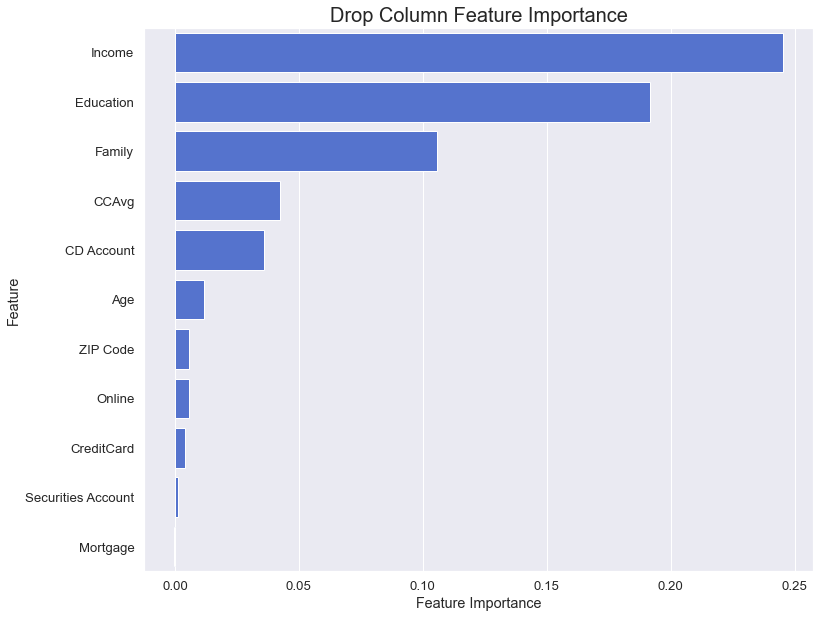

In [77]:
drop_column_importance_plot(dt_opt, X_train, y_train)

En la salida del método de importancia de características Drop-Column, observamos que algunas características tienen una importancia negativa. Para mejorar el rendimiento del modelo, eliminaremos estas características

In [78]:
# Buscamos las variables importantes con un valor de feature_importance positivo
feature_importances = drop_column_importance(dt_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature'] # Threshold value of 0.01

# Filtramos el dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Vamos a ajustar los hiperparámetros de nuestro modelo nuevamente después de eliminar las características irrelevantes:

In [79]:
# Creamos el objecto  Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=0)

# Buscamos el mejor clasificador con los hiperparámetros óptimos
dt_opt = tune_clf_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.8948421052631579, 1: 0.10515789473684212}, 'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6}


### <font color='royalblue'> Paso 13.3: Evaluación del Modelo de Árbol de Decisión </font>
Vamos a evaluar el rendimiento de nuestro clasificador de Árbol de Decisión final utilizando la función model_evaluation:



	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3570
           1       1.00      0.91      0.95       346

    accuracy                           0.99      3916
   macro avg       1.00      0.95      0.97      3916
weighted avg       0.99      0.99      0.99      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.92      0.89      0.90        87

    accuracy                           0.98       979
   macro avg       0.95      0.94      0.95       979
weighted avg       0.98      0.98      0.98       979



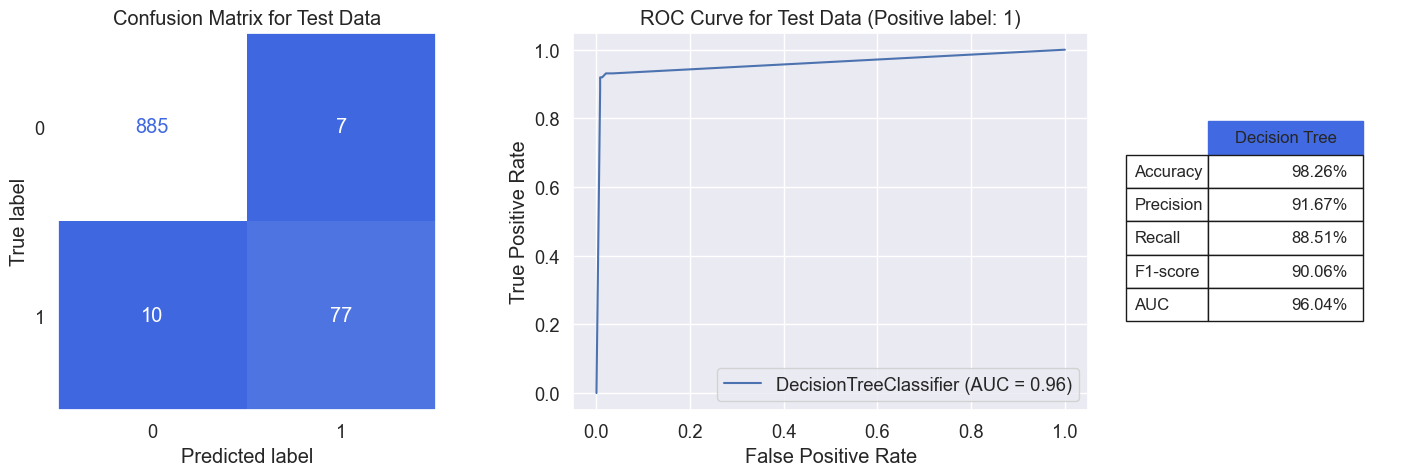

In [80]:
model_evaluation(dt_opt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [81]:
# Guardamos el rendimiento final de Decision Tree classifier
dt_result = metrics_calculator(dt_opt, X_test, y_test, 'Decision Tree')

### <font color='royalblue'> Paso 14: Ensemble learning </font>

**Ensemble learning** is a machine learning technique that combines the predictions of multiple models to make more accurate and robust predictions. The idea behind ensemble learning is that by combining several models, or weak learners, to solve the same problem, the resulting ensemble model can perform better than any individual model. There are three main ensemble learning methods:

**Ensemble learning** es una técnica de aprendizaje automático que combina las predicciones de múltiples modelos para obtener predicciones más precisas y robustas. La idea detrás del aprendizaje por conjunto es que al combinar varios modelos, o aprendices débiles, para resolver el mismo problema, el modelo de conjunto resultante puede rendir mejor que cualquier modelo individual. Existen tres métodos principales de aprendizaje por conjunto:

* **Bagging** que significa agregación bootstrap, es un metaalgoritmo de aprendizaje automático diseñado para mejorar la estabilidad y precisión de los algoritmos de aprendizaje automático utilizados en la clasificación estadística y la regresión. En el método de bagging, se entrenan múltiples instancias del mismo modelo base en paralelo utilizando diferentes muestras bootstrap de los datos, y los resultados se agregan mediante una operación de promedio. El bagging es más adecuado para modelos base con sesgo bajo pero alta varianza, ya que la operación de promedio reduce la varianza del modelo de conjunto final.

* **Boosting**  es una técnica iterativa en la que se entrenan múltiples instancias del mismo modelo base de manera secuencial. En cada iteración, el aprendiz débil actual se entrena en función de los aprendices débiles anteriores y de su desempeño en los datos. Boosting es más adecuado para modelos base con baja varianza pero alto sesgo, ya que la estrategia iterativa de aprendizaje reduce el sesgo del modelo de conjunto final.

* **Stacking** es una técnica en la que se entrenan diferentes modelos base de manera independiente, y un meta-modelo se entrena sobre ellos para predecir resultados basados en las salidas de los modelos base. En el stacking, los modelos base se utilizan como características para el meta-modelo, que realiza las predicciones finales basándose en la información combinada de todos los modelos base.

<font color='royalblue'> Los árboles de decisión (DTs) se utilizan con frecuencia como modelos base en métodos de ensamblaje debido a varias propiedades que los hacen adecuados para este propósito: </font>

1. **Simples y fáciles de entender:** Los árboles de decisión son simples y fáciles de entender, lo que los convierte en una buena elección para usar como modelos base en métodos de ensamblaje.
2. **Manejo de relaciones no lineales:** Los árboles de decisión pueden manejar relaciones no lineales entre características y variables objetivo, lo que los hace una buena elección para modelar conjuntos de datos complejos.
3. **Manejo de valores faltantes y valores atípicos:**  Los árboles de decisión pueden manejar valores faltantes y valores atípicos en los datos, lo cual es importante para conjuntos de datos del mundo real que a menudo presentan estos problemas.
4. **Captura de interacciones entre características:** Los árboles de decisión pueden capturar interacciones entre características, lo que es importante para capturar relaciones complejas en los datos.
5. **Rápidos para entrenar y hacer predicciones:** Los árboles de decisión se entrenan rápidamente y hacen predicciones, lo que los hace adecuados para su uso en modelos de aprendizaje automático a gran escala.
6. **Proporcionan importancia de características:** Los árboles de decisión proporcionan la importancia de las características, lo que puede ser útil para comprender qué características contribuyen más a las predicciones realizadas por el modelo.

**Los modelos de bagging más importantes basados en clasificadores de árboles de decisión son**

* **Random Forest:** Random Forest es un método de aprendizaje en conjunto que utiliza árboles de decisión como su modelo base. Los árboles en un bosque aleatorio se crean a partir de muestras de datos bootstrap y un subconjunto de características seleccionadas al azar. Esto ayuda a reducir la correlación entre los árboles y hace que el modelo sea más robusto ante datos faltantes. El objetivo de los bosques aleatorios es disminuir la varianza del modelo al combinar múltiples árboles de decisión profundos. La combinación de bagging y la selección aleatoria de subespacios de características resulta en un modelo más robusto y preciso en comparación con los árboles de decisión individuales. <br> <br>

* **Extra Trees:** Extra trees son una extensión de los bosques aleatorios que utilizan divisiones aleatorias en lugar de optimizar las divisiones basadas en la ganancia de información u otros criterios. Esto hace que los árboles extra sean más rápidos de entrenar que los bosques aleatorios y menos propensos al sobreajuste. <br> <br>

**Los modelos de boosting más importantes son:**

* **Adaboost:** Este es uno de los algoritmos de boosting más antiguos y populares. Entrena una serie de árboles de decisión débiles y asigna más peso a las muestras clasificadas incorrectamente en cada iteración. <br><br>
* **Gradient Boosting:** Este es un algoritmo de boosting de propósito general que funciona bien con una variedad de modelos débiles, incluidos los árboles de decisión. Utiliza el método de descenso de gradiente para minimizar la función de pérdida y encontrar la mejor combinación de modelos débiles. <br><br>
* **XGBoost:** Este es una implementación optimizada de gradient boosting y uno de los algoritmos más ampliamente utilizados en la comunidad de aprendizaje automático. Es conocido por su rápida velocidad de entrenamiento, escalabilidad y capacidad para manejar conjuntos de datos grandes. <br><br>

* **LightGBM:** Este es otra implementación optimizada de gradient boosting diseñada para conjuntos de datos grandes y que ha sido ampliamente adoptada en la industria.




### <font color='royalblue'> Paso 15: Construcción del Modelo de Bosque Aleatorio </font>

**Random Forest** es un método de aprendizaje en conjunto para clasificación, regresión y otras tareas. Funciona construyendo una multitud de árboles de decisión durante el entrenamiento y produciendo la clase que es la moda de las clases (clasificación) o la predicción promedio (regresión) de los árboles individuales. Los árboles en un bosque aleatorio se crean a partir de muestras seleccionadas al azar del conjunto de datos de entrenamiento y un subconjunto de características. Esto ayuda a reducir el sobreajuste y mejora la estabilidad al combinar múltiples árboles, de ahí el nombre “Forest” (bosque).

### <font color='royalblue'> Paso 15.1: Ajuste de Hiperparámetros del Bosque Aleatorio </font>

Ajustar los hiperparámetros de un clasificador de Bosque Aleatorio puede mejorar su rendimiento en un problema dado. Los hiperparámetros controlan la complejidad y el comportamiento del modelo, y sus valores pueden tener un impacto significativo en la precisión y capacidad de generalización del modelo. Por ejemplo, establecer la profundidad máxima de los árboles demasiado alta puede provocar sobreajuste, mientras que establecerla demasiado baja puede resultar en subajuste. Lo mismo ocurre con otros hiperparámetros, como el número mínimo de muestras requeridas para dividir un nodo o la cantidad de características consideradas al dividir un nodo. Ajustar los hiperparámetros ayuda a encontrar la mejor combinación de valores que resulta en el mejor rendimiento en el problema particular que se está resolviendo. 

### <font color='royalblue'> The hyperparameters of a Random Forest classifier are: </font>
> * **n_estimators:** El número de árboles en el bosque.
> * **criterion:** La función para medir la calidad de una división. Criterios comunes incluyen la impureza de Gini y la ganancia de información.
> * **max_depth:** La profundidad máxima de un árbol se utiliza para controlar la complejidad del modelo y prevenir el sobreajuste.
> * **min_samples_split:** El número mínimo de muestras necesarias para dividir un nodo interno.
> * **min_samples_leaf:** El número mínimo de muestras necesarias para estar en un nodo hoja.
> * **bootstrap:** ¿Muestrear con reemplazo al construir los árboles en el bosque?.
> * **oob_score:** "¿Conviene utilizar muestras fuera de bolsa (OOB) para estimar la precisión de generalización?.
> * **class_weight:** Pesos asociados a las clases.
> * **max_features:** El número máximo de características a considerar al dividir un nodo. Puede establecerse como un número entero o un decimal (percentage) o 'sqrt' or 'log2'.

**Nota:** Los árboles que componen un bosque pueden ser **superficiales**, lo que significa que tienen un número limitado de ramas o niveles, o **profundos**, lo que significa que tienen muchas ramas o niveles y no están completamente desarrollados. Los **árboles profundos** tienen **sesgo bajo** pero **varianza alta**, por lo que son opciones relevantes para los métodos de bagging que se centran principalmente en reducir la varianza. Consideramos tener árboles profundos al elegir el rango de valores para los hiperparámetros del bosque aleatorio.


In [85]:
# Ponderaciones asociadas a las clases
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Definimos el conjunto de hiperparámetros a buscar
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': np.arange(5, 12),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': class_weights
}

Vamos a llamar a la función tune_clf_hyperparameters para la optimización de hiperparámetros:

In [86]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Creamos el objecto random forest classifier 
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Buscamos el mejor clasificador con los hiperparámetros óptimos
rf_opt = tune_clf_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.5793684210526315, 1: 0.42063157894736847}, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### <font color='royalblue'> Paso 15.2: Selección de subconjunto de características del Bosque Aleatorio </font>


La selección de características es importante para el clasificador de bosque aleatorio porque ayuda a mejorar el rendimiento del modelo, reducir el sobreajuste y acelerar el tiempo de entrenamiento al eliminar características irrelevantes, redundantes o ruidosas de los datos. Vamos a llamar a la función drop_column_importance_plot:


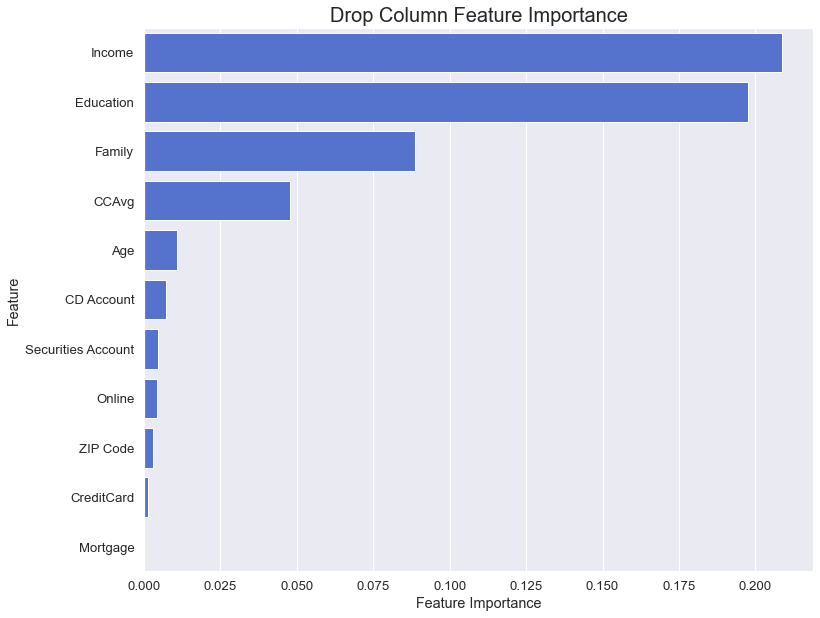

In [87]:
drop_column_importance_plot(rf_opt, X_train, y_train)

No se observan valores negativos entre las Importancias de las Características al eliminar columnas. Por lo tanto, todas las características son efectivas para estimar el objetivo y ninguna de ellas se considera perjudicial o redundante.

### <font color='royalblue'> Paso 15.3: Evaluación del Modelo de Bosque Aleatorio </font>

Vamos a evaluar el rendimiento de nuestro clasificador óptimo de Bosque Aleatorio utilizando la función model_evaluation:



	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      0.97      0.99       346

    accuracy                           1.00      3916
   macro avg       1.00      0.99      0.99      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.93      0.90      0.91        87

    accuracy                           0.98       979
   macro avg       0.96      0.94      0.95       979
weighted avg       0.98      0.98      0.98       979



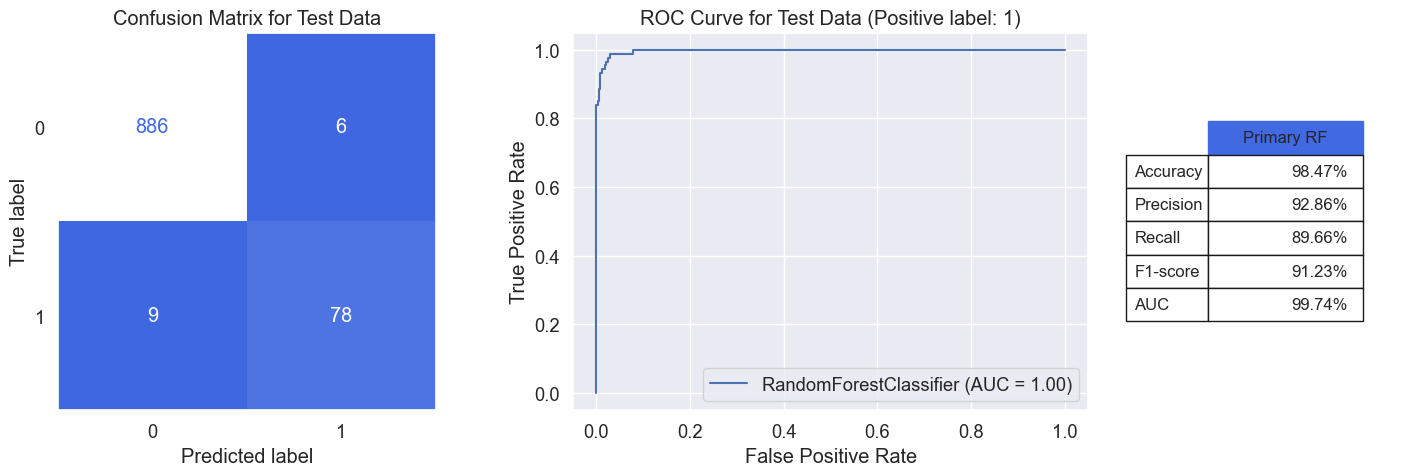

In [88]:
model_evaluation(rf_opt, X_train, X_test, y_train, y_test, 'Primary RF')

Si comparamos los valores de precisión, recall y f1-score para la clase 1 (la clase más importante) en ambos conjuntos de entrenamiento y prueba, observamos una ligera disminución en las puntuaciones en el conjunto de datos de prueba en comparación con el entrenamiento, lo que indica que el modelo está bastante sobreajustado. El sobreajuste del modelo se debe a su alta varianza, y a continuación, intentamos liberar el modelo del sobreajuste aplicando un pequeño cambio en el valor de los hiperparámetros, con la esperanza de que el rendimiento del modelo mejore en los datos de prueba.

#### <font color='royalblue'> ¿Cómo aumentan la varianza del modelo cada uno de estos hiperparámetros del clasificador Random Forest?" </font>

> * **n_estimators** - Aumentar el número de árboles en el bosque aumentará la varianza, ya que más árboles en el bosque pueden capturar patrones más diversos en los datos.
> * **max_depth** - Aumentar la profundidad máxima de un árbol permite que el árbol capture patrones más complejos en los datos, aumentando su varianza.
> * **min_samples_split** - Disminuir el número mínimo de muestras requeridas para dividir un nodo interno aumentará la varianza, ya que permite que ocurran más divisiones.
> * **min_samples_leaf** - Reducir el número mínimo de muestras requeridas para estar en un nodo hoja aumentará la varianza, ya que permite la formación de hojas más pequeñas.
> * **max_features** - Aumentar el número máximo de características a considerar al dividir un nodo aumentará la varianza, ya que permite considerar conjuntos de características más diversos al dividir.
> * **bootstrap** - Realizar muestreo con reemplazo al construir los árboles en el bosque aumentará la varianza, ya que permite utilizar conjuntos de muestras más diversos para cada árbol.

Entre los valores óptimos obtenidos para los hiperparámetros, solo aumentamos el valor de min_samples_leaf de 2 a 6 para reducir parcialmente la varianza del modelo:

In [89]:
# Constrimos el objeto clasificador random forest teniendo en cuenta los valores óptimos obtenidos para los hiperparámetros
rf_final = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=100, 
                                  max_depth = 9,  min_samples_leaf=6, min_samples_split=2,
                                  class_weight={0: 0.58, 1: 0.42}, random_state=0)
                             
                            
# Entrenamos el modelo Random Forest final
rf_final.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.58, 1: 0.42}, max_depth=9,
                       max_features=None, min_samples_leaf=6, random_state=0)

Vamos a evaluar nuestro clasificador de Random Forest nuevamente:


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3570
           1       0.98      0.91      0.94       346

    accuracy                           0.99      3916
   macro avg       0.98      0.95      0.97      3916
weighted avg       0.99      0.99      0.99      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.89      0.92        87

    accuracy                           0.99       979
   macro avg       0.98      0.94      0.96       979
weighted avg       0.99      0.99      0.99       979



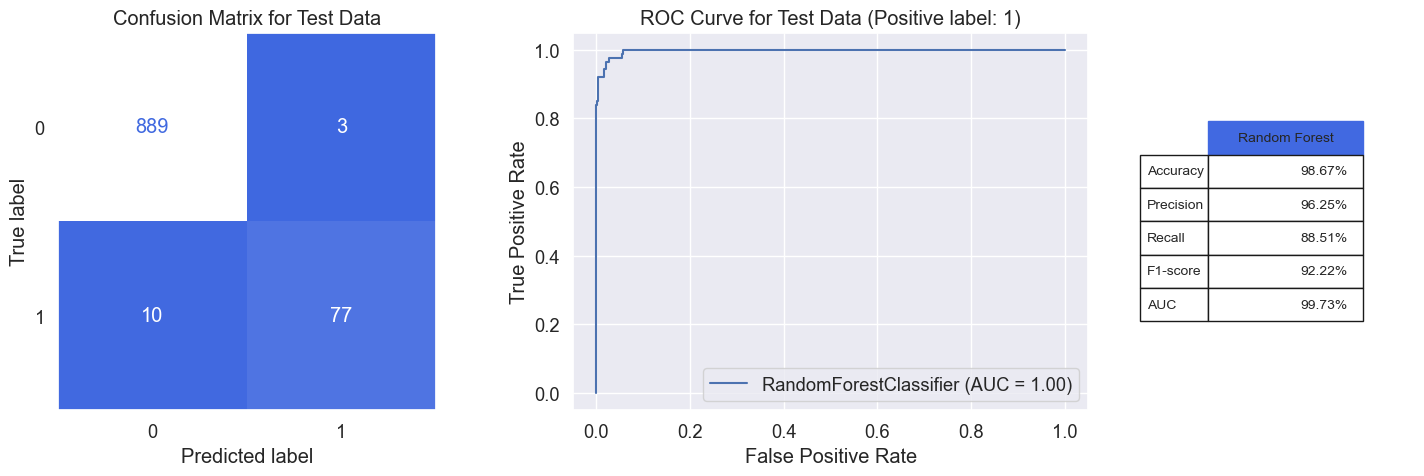

In [90]:
model_evaluation(rf_final, X_train, X_test, y_train, y_test, 'Random Forest')

Obtuvimos un notable 92% de puntuación F1 con un 99.73% de AUC para nuestro clasificador de Bosques Aleatorios. De los 979 clientes bancarios, el modelo cometió errores en solo 13 casos al predecir si el cliente acepta o no el préstamo. 

In [91]:
# Guardamos el rendimeinto final del clasificador Random Forest
rf_result = metrics_calculator(rf_final, X_test, y_test, 'Random Forest')

### <font color='royalblue'> Paso 16: Construcción del Modelo de Árboles Extra </font>

**Extra Trees (Extremely Randomized Trees)** es un método de aprendizaje en conjunto para problemas de clasificación y regresión. Es una variante del popular algoritmo de Bosque Aleatorio y utiliza la aleatorización en la construcción de árboles de decisión para crear un bosque de árboles.

In a **Random Forest**, Cada árbol en el conjunto se construye utilizando un subconjunto aleatorio de las características y una muestra de entrenamiento aleatoria. La predicción final se realiza tomando un promedio (para regresión) o una votación mayoritaria (para clasificación) de las predicciones hechas por todos los árboles en el conjunto. Sin embargo, en un clasificador de **Árboles Extremadamente Aleatorios**, cada árbol en el conjunto se construye utilizando una muestra de entrenamiento aleatoria y se utiliza un valor **umbral aleatorio para cada característica para dividir las muestras**. Esto significa que el clasificador de **Árboles Extremadamente Aleatorios** permite más aleatoriedad en la construcción de los árboles en comparación con el Bosque Aleatorio, lo que puede hacer que los Árboles Extremadamente Aleatorios sean más adecuados para ciertos tipos de conjuntos de datos.

Otra diferencia entre los dos es que el clasificador de Árboles Extremadamente Aleatorios tiende a tener una varianza ligeramente mayor en comparación con el Bosque Aleatorio, lo que significa que puede ser más propenso a sobreajustar los datos de entrenamiento. Sin embargo, esta mayor varianza también puede llevar a un mejor rendimiento en ciertos conjuntos de datos, lo que hace que los Árboles Extremadamente Aleatorios sean una alternativa útil para considerar en algunos casos.


### <font color='royalblue'> Paso 16.1: Ajuste de Hiperparámetros para Árboles Extremadamente Aleatorios </font>

Los hiperparámetros del clasificador Extra Trees son similares a los del Random Forest. Por lo tanto, nuevamente establecemos el rango de valores para cada hiperparámetro que queremos considerar para nuestro clasificador Extra Trees, y luego utilizamos la función tune_clf_hyperparameters para encontrar la mejor combinación de hiperparámetros que brinde los mejores resultados:

**Nota:** Ajustar los hiperparámetros del Random Forest puede ser un proceso que consume tiempo. Esto se debe a que encontrar los valores óptimos para los hiperparámetros implica entrenar varios clasificadores de árboles de decisión con diferentes combinaciones de valores de hiperparámetros y evaluar su rendimiento, lo cual puede ser computacionalmente costoso y llevar tiempo. Por lo tanto, realizamos la sintonización de hiperparámetros una vez y luego redujimos el rango de valores de hiperparámetros en el siguiente param_grid:

In [92]:
# Ponderaciones asociadas con las clases 
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Definimos el conjunto de hiperparámetros a buscar

param_grid = {
    'n_estimators': [70, 100, 150], 
    'max_depth': [10,12,14],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'class_weight': class_weights
}

Vamos a llamar a la función tune_clf_hyperparameters para la sintonización de hiperparámetros:

In [93]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Creamos el objecto clasificador random forest classifier 
et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Buscamos el mejor clasificador con los hiperparámetros óptimos
et_opt = tune_clf_hyperparameters(et, param_grid, X_train, y_train)

Best hyperparameters:
 {'class_weight': {0: 0.6845263157894736, 1: 0.31547368421052635}, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


### <font color='royalblue'> Paso 16.2: Selección de subconjunto de características de Extra Trees </font>

La selección de características también puede ser importante para el Clasificador de Árboles Extra. La selección de características ayuda a reducir la dimensionalidad del conjunto de datos y a elegir un subconjunto de características relevantes que tienen un gran impacto en el rendimiento predictivo del modelo. Esto puede conducir a una mejor interpretación del modelo, menos sobreajuste y tiempos de entrenamiento más rápidos. Sin embargo, la importancia de la selección de características para el Clasificador de Árboles Extra puede variar según el conjunto de datos específico y el problema que se está resolviendo. Siempre es una buena práctica experimentar y evaluar el impacto de la selección de características en el rendimiento del modelo. 

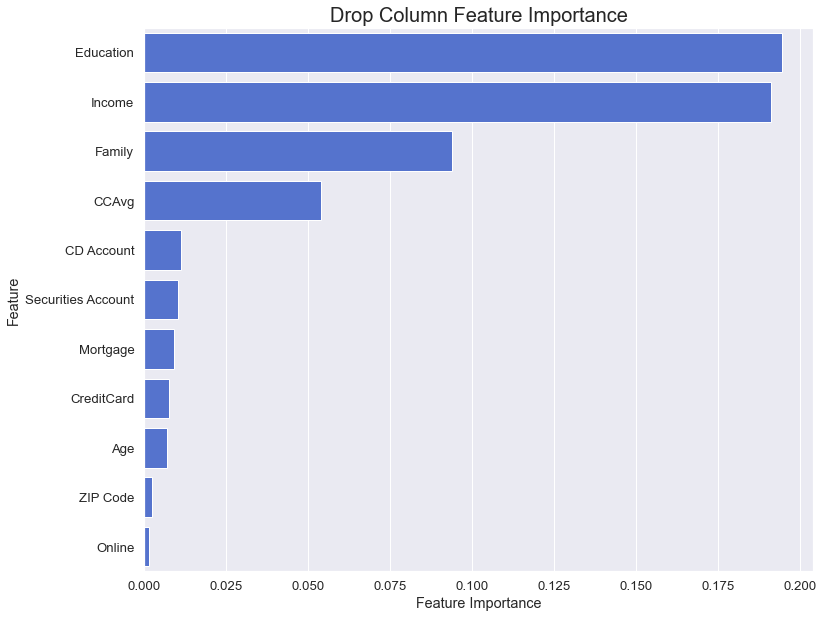

In [94]:
drop_column_importance_plot(et_opt, X_train, y_train)

Nuevamente, no se observan valores negativos entre las Importancias de las Características eliminadas. Por lo tanto, todas las características son efectivas para estimar el objetivo y ninguna de ellas se considera redundante. 

### <font color='royalblue'> Paso 16.3: Evaluación del Modelo de Árboles Extra </font>

Vamos a evaluar el rendimiento de nuestro clasificador óptimo de Árboles Extra utilizando la función de evaluación del modelo:


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.91      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



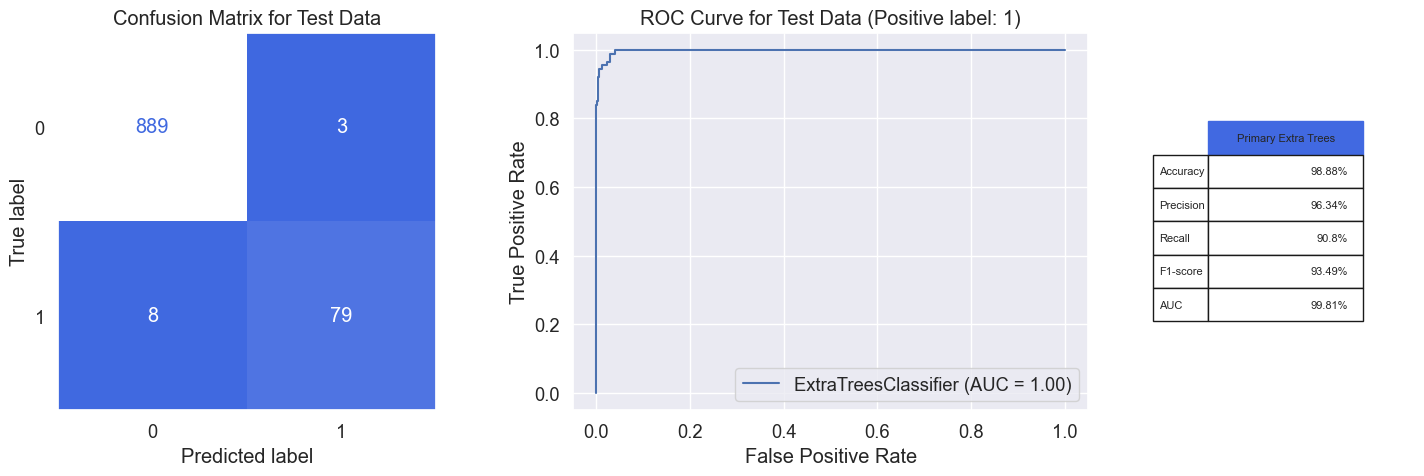

In [95]:
model_evaluation(et_opt, X_train, X_test, y_train, y_test, 'Primary Extra Trees')

La comparación de precisión, recall y f1-score para la clase 1 entre los conjuntos de datos de entrenamiento y prueba sugiere que el modelo está ligeramente sobreajustado. Si los valores para la clase 1 muestran una disminución significativa en el rendimiento en el conjunto de prueba en comparación con el conjunto de entrenamiento, indica que el modelo ha aprendido demasiado bien los datos de entrenamiento y no se ha generalizado correctamente a nuevos datos no vistos. Este sobreajuste conduce a un mal rendimiento en el conjunto de prueba y sugiere que el modelo no es adecuado para hacer predicciones precisas sobre nuevos datos.

Basado en la explicación proporcionada en la sección 15.3, al aumentar el valor de min_samples_leaf de 2 a 3, el modelo se vuelve menos complejo y se reduce la varianza del modelo. 

In [96]:
# Construimos el objecto Extra Trees classifier considerando los valores óptimos de los hiperparámetros
et_final = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=70, 
                                max_depth = 14,  min_samples_leaf=1, min_samples_split=3,
                                class_weight= {0: 0.95, 1: 0.05}, random_state=0)
                             
                            
# Entrenamos el modelo final Extra Trees
et_final.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight={0: 0.95, 1: 0.05},
                     max_depth=14, max_features=None, min_samples_split=3,
                     n_estimators=70, random_state=0)


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      0.96      0.98       346

    accuracy                           1.00      3916
   macro avg       1.00      0.98      0.99      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.91      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



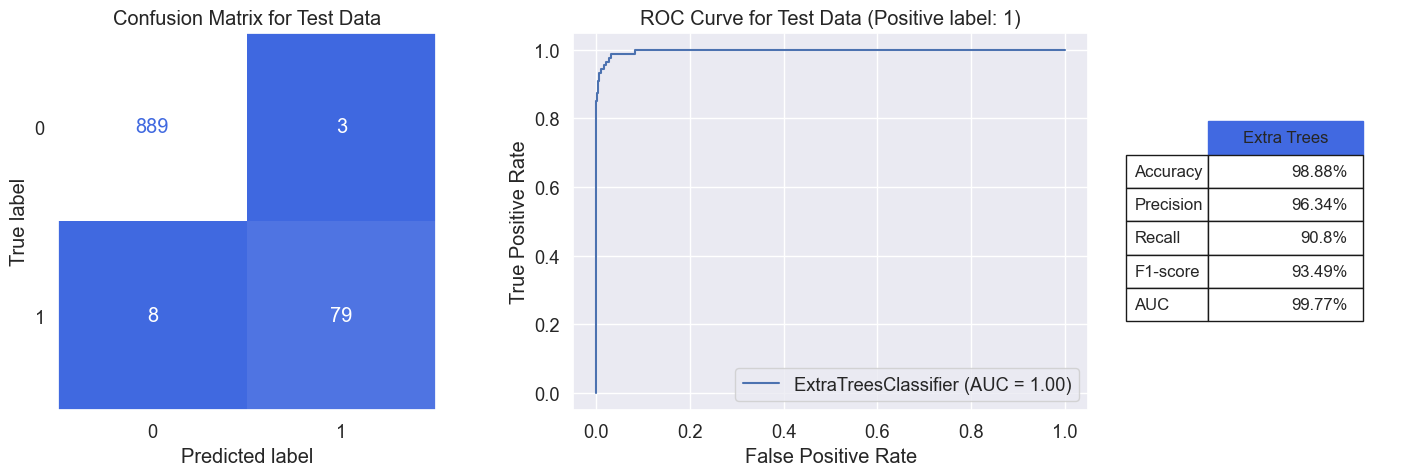

In [97]:
model_evaluation(et_final, X_train, X_test, y_train, y_test, 'Extra Trees')

La comparación de precisión, recall y f1-score para la clase 1 entre los conjuntos de datos de entrenamiento y prueba sugiere que el modelo está ligeramente sobreajustado. Si los valores para la clase 1 muestran una disminución significativa en el rendimiento en el conjunto de prueba en comparación con el conjunto de entrenamiento, indica que el modelo ha aprendido demasiado bien los datos de entrenamiento y no se ha generalizado correctamente a nuevos datos no vistos. Este sobreajuste conduce a un mal rendimiento en el conjunto de prueba y sugiere que el modelo no es adecuado para hacer predicciones precisas sobre nuevos datos.

Basado en la explicación proporcionada en la sección 15.3, al aumentar el valor de min_samples_leaf de 2 a 3, el modelo se vuelve menos complejo y se reduce la varianza del modelo. 

Como se puede observar, el modelo ya no está sobreajustado y el rendimiento del modelo en los datos de prueba ha mejorado en comparación con el modelo anterior. Obtuvimos un asombroso 93% de f1-score con un 99.77% de AUC para nuestro clasificador Extra Trees, que es nuestro mejor clasificador hasta ahora. De los 979 clientes bancarios, el modelo cometió errores en solo 11 casos al predecir si el cliente acepta o no el préstamo.

In [98]:
# Guardamos el rendimiento del clasificador Extra Trees
et_result = metrics_calculator(et_final, X_test, y_test, 'Extra Trees')

### <font color='royalblue'> Paso 17: Construcción del Modelo AdaBoost </font>

AdaBoost (Adaptive Boosting) is a popular boosting ensemble learning algorithm that is used for classification and regression tasks. It combines multiple "weak" classifiers to create a strong classifier that makes accurate predictions. The weak classifiers are trained one by one and the algorithm adjusts the weights of the training instances based on their misclassification rates. The idea behind AdaBoost is to focus on the samples that are misclassified by the previous weak classifiers, so that the subsequent weak classifiers can do a better job in classifying those samples. In this way, the algorithm tries to improve the overall accuracy of the classifier by combining the outputs of multiple weak classifiers.

The term "weak classifier" refers to a simple classifier that is not highly accurate, but when combined with other weak classifiers, results in a strong overall classifier. Typically, decision trees are used as the weak classifiers in AdaBoost. However, any machine learning algorithm that accepts weights on the training data can be used as the base learner in AdaBoost.

### <font color='royalblue'> Paso 17.1: Ajuste de hiperparámetros de AdaBoost </font>

El ajuste de hiperparámetros generalmente es necesario para la mayoría de los algoritmos de aprendizaje automático, incluido el clasificador AdaBoost. Puede ayudar a optimizar el rendimiento del modelo y evitar el sobreajuste o el subajuste.

### <font color='royalblue'> Los hiperparámetros del clasificador AdaBoost incluyen: </font>

> * **learning rate:** Este parámetro determina la contribución de cada aprendiz débil en la predicción final. Un learning rate más bajo resulta en una convergencia más lenta, pero una predicción más precisa.
> * **number of estimators:** Esto es el número máximo de aprendices débiles que se utilizarán para crear el clasificador fuerte final. Un mayor número de estimadores puede llevar a una predicción más precisa, pero también aumenta el tiempo de cálculo.
> * **estimator:** El algoritmo utilizado para el aprendiz débil puede seleccionarse en función del problema en cuestión. En este caso, elegimos el Árbol de Decisión

**Nota:** Además de los hiperparámetros del clasificador AdaBoost, como la tasa de aprendizaje, el número de estimadores y la estrategia de muestreo, también es necesario optimizar los hiperparámetros del estimador base para lograr el mejor rendimiento. Los árboles poco profundos tienen un alto sesgo pero baja varianza, por lo que son opciones relevantes para los métodos de refuerzo que se centran principalmente en reducir el sesgo. Los árboles poco profundos permiten que el algoritmo de refuerzo se concentre en muestras difíciles de clasificar.

Establecemos el rango de valores para cada hiperparámetro que queremos considerar para nuestro clasificador AdaBoost y luego utilizamos la función tune_clf_hyperparameters para encontrar la mejor combinación de hiperparámetros que proporcione los mejores resultados:

In [99]:
# Definimos el conjunto de hiperparámetros para AdaBoost
ada_param_grid = {
    'base_estimator__max_depth': [3, 5, 7],
    'base_estimator__min_samples_split': [3, 5, 7],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.8, 0.9, 1]
}

Vamos a llamar a la función tune_clf_hyperparameters para ajustar los hiperparámetros:

In [100]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Creamos el estimador del clasificador Decision Tree como la base
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0)

# Creamos el clasificador AdaBoost usando  Decision Tree como base del estimador
ada = AdaBoostClassifier(base_estimator=dt, random_state=0)

# Buscamos el mejor estimador AdaBoost con los valores óptimos de los hiperparámetros
ada_opt = tune_clf_hyperparameters(ada, ada_param_grid, X_train, y_train)

Best hyperparameters:
 {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 5, 'learning_rate': 0.8, 'n_estimators': 150}


### <font color='royalblue'> Paso 17.2: Selección de subconjunto de características para AdaBoost </font>

La selección de características puede ser importante para un clasificador AdaBoost. La selección de características ayuda a reducir la dimensionalidad de los datos, disminuir el costo computacional y prevenir el sobreajuste. Además, puede mejorar la interpretabilidad del modelo y aumentar la precisión del clasificador al centrarse en las características más relevantes. Sin embargo, el impacto específico de la selección de características en un clasificador AdaBoost puede variar según el problema y los datos:


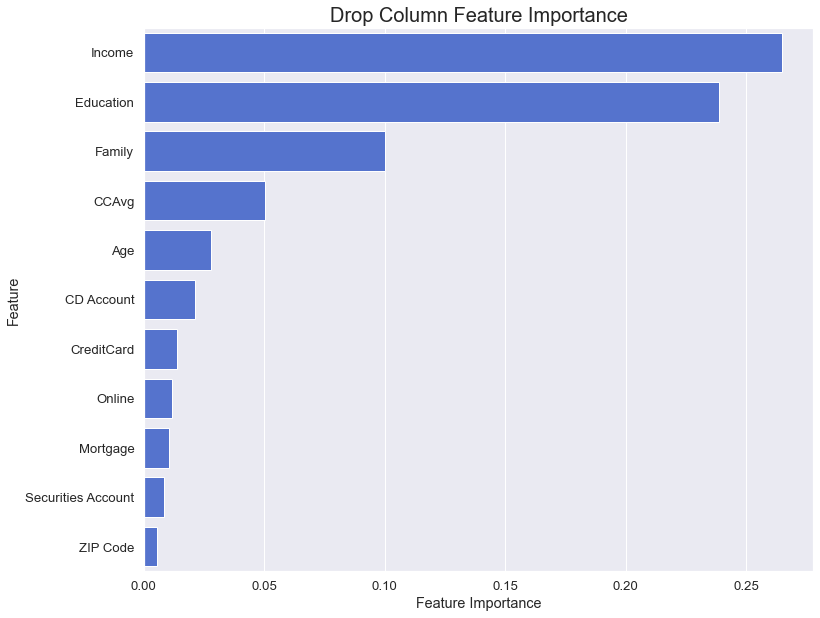

In [101]:
drop_column_importance_plot(ada_opt, X_train, y_train)

El resultado del análisis de importancia de características muestra que ninguna de las características tiene valores negativos para sus importancias al eliminar columnas. Esto indica que todas las características contribuyen positivamente a la estimación del objetivo y ninguna de ellas puede considerarse innecesaria o redundante. Todas las características se consideran efectivas para predecir el objetivo

### <font color='royalblue'> Paso 17.3: Evaluación del Modelo AdaBoost </font>

Vamos a evaluar el rendimiento de nuestro clasificador AdaBoost óptimo utilizando la función de evaluación del modelo:



	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.97      0.90      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



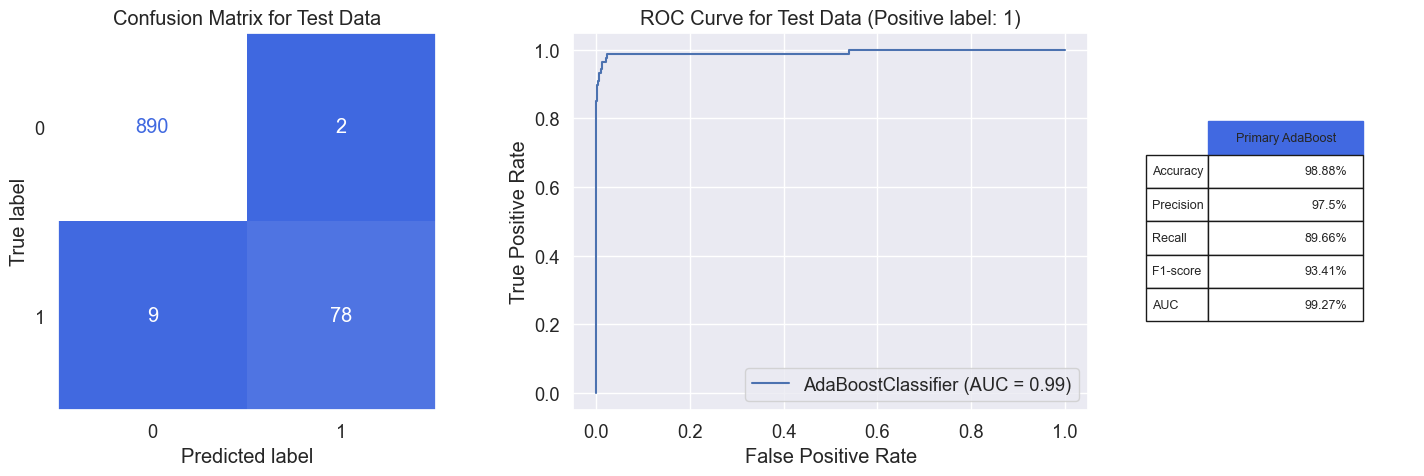

In [102]:
model_evaluation(ada_opt, X_train, X_test, y_train, y_test, 'Primary AdaBoost')

Las métricas de rendimiento para la clase minoritaria en los datos de prueba indican que el modelo no está sobreajustando completamente, pero podría no ser el mejor modelo para el problema. El sobreajuste del clasificador se debe a su alta varianza, y para evitarlo, podemos probar técnicas de regularización, lo que implica aplicar un pequeño cambio en el valor de los hiperparámetros para reducir la varianza del clasificador.

#### <font color='royalblue'> Para reducir la varianza de nuestro clasificador AdaBoost mediante la sintonización de hiperparámetros, podemos seguir estos pasos: </font>

> * **Disminuir el número de árboles en el modelo:** AdaBoost utiliza múltiples aprendices débiles (en este caso, árboles de decisión) para construir un modelo sólidoDisminuir el número de árboles en el modelo puede reducir la varianza del modelo.
> * **Disminuir la profundidad máxima de los árboles de decisión:** Disminuir la profundidad máxima de los árboles de decisión puede reducir la varianza del modelo.
> * **Aumentar el número mínimo de muestras necesarias para dividir un nodo interno:** Aumentar el número mínimo de muestras necesarias para dividir un nodo interno puede reducir la varianza del modelo. 
> * **Aumentar el número mínimo de muestras necesarias para estar en un nodo hoja:** Aumentar el número mínimo de muestras necesarias para estar en un nodo hoja puede reducir la varianza del modelo.
> * **Disminuir la tasa de aprendizaje** La tasa de aprendizaje en AdaBoost determina el peso que se asigna a cada aprendiz débilDisminuir la tasa de aprendizaje puede hacer que el modelo sea menos propenso al sobreajuste. 

Entre los valores óptimos obtenidos para los hiperparámetros, solo disminuimos el valor de la tasa de aprendizaje de 0.9 a 0.8 con el objetivo de reducir parcialmente la varianza del modelo. 

In [103]:
# Creamos el clasificador Decision Tree como base del estimador
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0, max_depth=5, min_samples_leaf=2, min_samples_split=5)

# Creamos el clasificador AdaBoost usando Decision Tree como base del estimador
ada_final = AdaBoostClassifier(base_estimator=dt, random_state=0, learning_rate=0.8, n_estimators=100)

# Entrenamos el modelo final AdaBoost 
ada_final.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         random_state=0),
                   learning_rate=0.8, n_estimators=100, random_state=0)

Evaluemos nuestro clasificador final de AdaBoost:


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.97      0.89      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.94      0.96       979
weighted avg       0.99      0.99      0.99       979



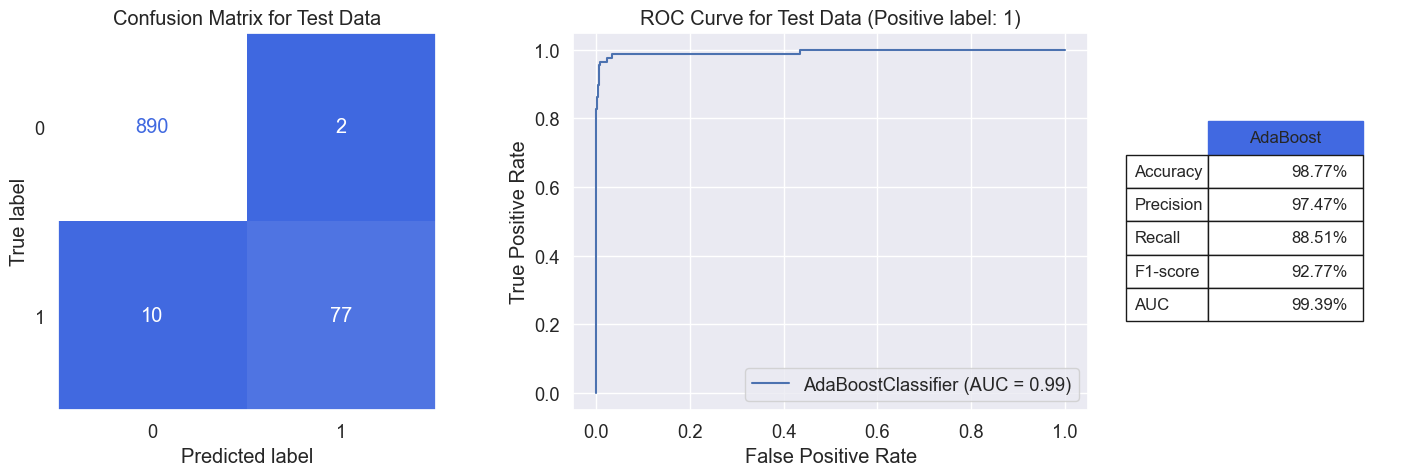

In [104]:
model_evaluation(ada_final, X_train, X_test, y_train, y_test, 'AdaBoost')

La varianza del modelo se ha reducido, y por lo tanto, el rendimiento del modelo en los datos de prueba ha mejorado. Dado que la diferencia en las puntuaciones entre los datos de prueba y entrenamiento no es grande y la puntuación AUC es alta, podemos ignorarla. El f1-score obtenido en los datos de prueba es casi igual al de los modelos de bagging anteriores.

**Nota:** La métrica **AUC (Área Bajo la Curva)** mide el rendimiento de un clasificador binario trazando la tasa de verdaderos positivos frente a la tasa de falsos positivos y calculando el área bajo la curva. Un modelo que no está sobreajustado tendrá un alto AUC, cercano a 1, lo que indica que tiene un buen equilibrio entre predicciones verdaderos positivos y falsos positivos. Por otro lado, un modelo que está sobreajustando puede tener una alta precisión en el conjunto de entrenamiento pero un AUC más bajo en el conjunto de validación, ya que podría estar haciendo muchas predicciones falsos positivos. Por lo tanto, una puntuación alta de AUC sugiere que el modelo no está sobreajustando y tiene un buen rendimiento de generalización en datos nuevos y no vistos.

In [105]:
# Guardamos el rendimiento del clasificador AdaBoost 
ada_result = metrics_calculator(ada_final, X_test, y_test, 'AdaBoost')

### <font color='royalblue'> Paso 18: Construcción del Modelo de Gradient Boosting </font>

**Gradient Boosting** es una técnica de ensemble machine learning utilizada para problemas de clasificación y regresión. Produce un modelo de predicción en forma de un conjunto de modelos de predicción débiles, generalmente árboles de decisión. Construye el modelo de manera gradual, donde cada modelo subsiguiente intenta corregir los errores del modelo anterior. El algoritmo entrena iterativamente árboles de decisión de tal manera que estos se ajustan al gradiente negativo de la función de pérdida que se está optimizando. La predicción final se realiza combinando las salidas de todos los árboles individuales

**Nota**: La implementación del clasificador Gradient Boosting en el módulo de ensamblaje de scikit-learn (sklearn.ensemble.GradientBoostingClassifier) se basa en árboles de decisión como el estimador base. 


#### <font color='royalblue'> Paso 18.1: Ajuste de Hiperparámetros para Gradient Boosting </font>

Ajustar los hiperparámetros del Gradient Boosting es importante. Los hiperparámetros pueden afectar significativamente el rendimiento del modelo, y encontrar el conjunto óptimo de hiperparámetros es crucial para obtener buenos resultados. Una configuración inapropiada de los hiperparámetros puede llevar al sobreajuste o subajuste, y afectar la capacidad del modelo para generalizar a datos no vistos. 

#### <font color='royalblue'> The hyperparameters of Gradient Boosting Classifier include: </font>

> * **n_estimators:** El número de árboles en el conjunto.
> * **learning_rate:** La tasa de aprendizaje reduce la contribución de cada árbol por un factor de learning_rate. Es un parámetro para controlar la magnitud de la actualización, y el valor debe establecerse más bajo para un gran número de árboles.
> * **max_depth:** La profundidad máxima de los árboles de decisión individuales se refiere a cuántos niveles o divisiones puede tener un árbol. Cuanto más profundo es el árbol, más divisiones tiene y más complejo se vuelve el modelo.
> * **min_samples_split:** El número mínimo de muestras requeridas para estar en un nodo hoja.
> * **min_samples_leaf:** The minimum number of samples required to be at a leaf node.
> * **max_features:** El número de características a considerar al buscar la mejor división.
> * **subsample:** La fracción de muestras que se utilizará para ajustar los aprendices base individuales.
> * **loss:** La función de pérdida a optimizar. La función de pérdida predeterminada es “deviance”, que se refiere a la regresión logística para clasificación binaria y a la devianza multinomial para problemas de clasificación multiclase.
> * **criterion:** La función para medir la calidad de una división. Los criterios admitidos son “friedman_mse” para el error cuadrático medio, que se utiliza en problemas de regresión, y “entropy” o “gini” para la ganancia de información, que se emplean en problemas de clasificación.

Nuevamente establecemos el rango de valores para cada hiperparámetro que deseamos considerar para nuestro clasificador Gradient Boosting, y luego utilizamos la función tune_clf_hyperparameters para encontrar la mejor combinación de hiperparámetros que brinde los mejores resultados:

In [106]:
# Definimimos el conjunto de hiperparámetros para ajustar
gbc_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

Dado que la optimización de hiperparámetros en la cuadrícula mencionada puede ser muy demorada debido al gran tamaño de la cuadrícula, después de ejecutarla una vez y conocer los valores óptimos, reducimos el conjunto de valores de la cuadrícula. 

In [107]:
# Definimos el conjunto de hiperparámetros para ajustar
gbc_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'learning_rate': [0.3, 0.4, 0.5]
}

Vamos a llamar a la función tune_clf_hyperparameters para la optimización de hiperparámetros:

In [108]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Iniciamos el clasificador Gradient Boosting
gbc = GradientBoostingClassifier(max_features=None, loss='deviance', criterion='friedman_mse', random_state=0)

# Buscamos los mejores hiperparámetros para ajustar el proceso
gbc_opt = tune_clf_hyperparameters(gbc, gbc_param_grid, X_train, y_train)

Best hyperparameters:
 {'learning_rate': 0.3, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9}


#### <font color='royalblue'> Paso 18.2: Selección de subconjunto de características en Gradient Boosting </font>

El impacto específico de la selección de características en un clasificador de gradient boosting puede variar según el problema y los datos. En algunos casos, los algoritmos de gradient boosting pueden manejar un gran número de características sin una degradación significativa en el rendimiento, pero en otros casos, la selección de características aún puede ser beneficiosa. 


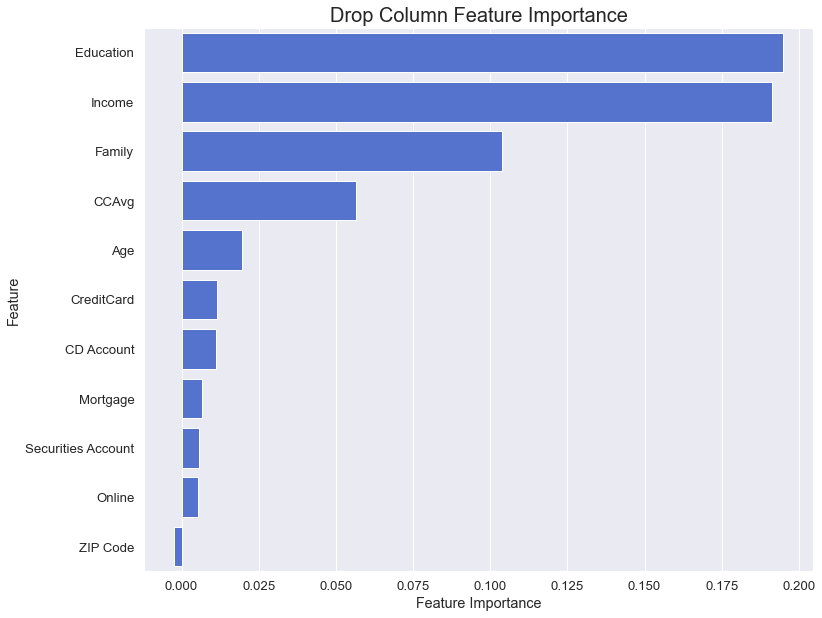

In [109]:
drop_column_importance_plot(gbc_opt, X_train, y_train)

El análisis de la importancia de las características revela que cada característica tiene un impacto positivo en la predicción del objetivo, lo que significa que ninguna de ellas tiene un impacto negativo.

### <font color='royalblue'> Paso 18.3: Evaluación del Modelo de Gradient Boosting </font>

Vamos a evaluar el rendimiento de nuestro clasificador óptimo de Gradient Boosting utilizando la función de evaluación del modelo:



	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.91      0.93        87

    accuracy                           0.99       979
   macro avg       0.97      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



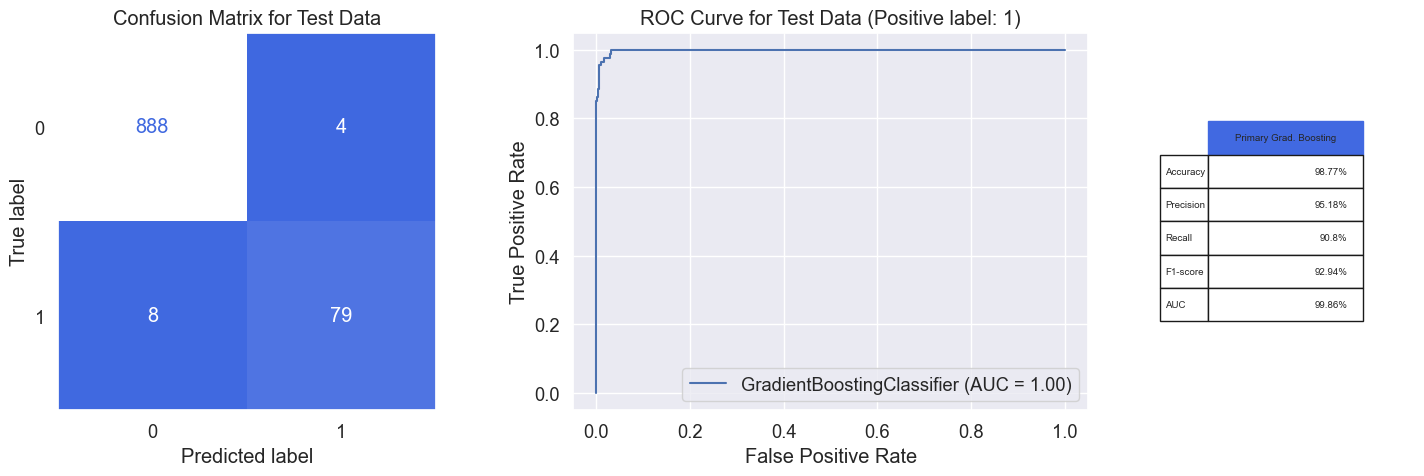

In [110]:
model_evaluation(gbc_opt, X_train, X_test, y_train, y_test, 'Primary Grad. Boosting')

Nuestro clasificador de Gradient Boosting está bastante sobreajustado en la clase minoritaria. Por lo tanto, nuevamente necesitamos reducir la varianza del clasificador al cambiar ligeramente el valor de los hiperparámetros

<font color='royalblue'> **¿Cómo reducir la varianza de nuestro clasificador Gradient Boosting ajustando los hiperparámetros del modelo?** </font>
>* **Número de árboles:** Podemos reducir el número de árboles para disminuir la varianza del modelo. Más árboles implican modelos más complejos, que son más propensos al sobreajuste.
>* **Profundidad máxima de los árboles:** Podemos reducir la profundidad máxima de los árboles en el modelo, lo que disminuirá la varianza del modelo al limitar el número de divisiones.
> * **Tasa de aprendizaje:** Disminuir la tasa de aprendizaje reducirá la magnitud de las actualizaciones de los parámetros del modelo, dificultando que el modelo se sobreajuste a los datos de entrenamiento.
> * **Submuestreo:** Podemos submuestrear los datos de entrenamiento tomando una muestra más pequeña durante cada iteración del entrenamiento del modelo. Esto evitará el sobreajuste al introducir aleatoriedad en el modelo.
> * **Hiperparámetros específicos del árbol:** Podemos reducir la varianza del modelo ajustando hiperparámetros específicos de los árboles de decisión. Por ejemplo, podemos aumentar el número mínimo de muestras requeridas para dividir un nodo o el número mínimo de muestras en una hoja. 

Entre los valores óptimos obtenidos para los hiperparámetros, solo disminuimos el valor de la tasa de aprendizaje (learning_rate) de 0.4 a 0.2 con el objetivo de reducir parcialmente la varianza del modelo

In [111]:
# Iniciamos el Clasificador Gradient Boosting 
gbc_final = GradientBoostingClassifier(max_features=None, loss='deviance', criterion='friedman_mse',
                                 learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0,
                                 min_samples_leaf=4, min_samples_split=2, random_state=0)

# Entrenamos el clasificador final AdaBoost 
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                           random_state=0)

Vamos a evaluar nuestro clasificador de Gradient Boosting final:


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.91      0.93        87

    accuracy                           0.99       979
   macro avg       0.97      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



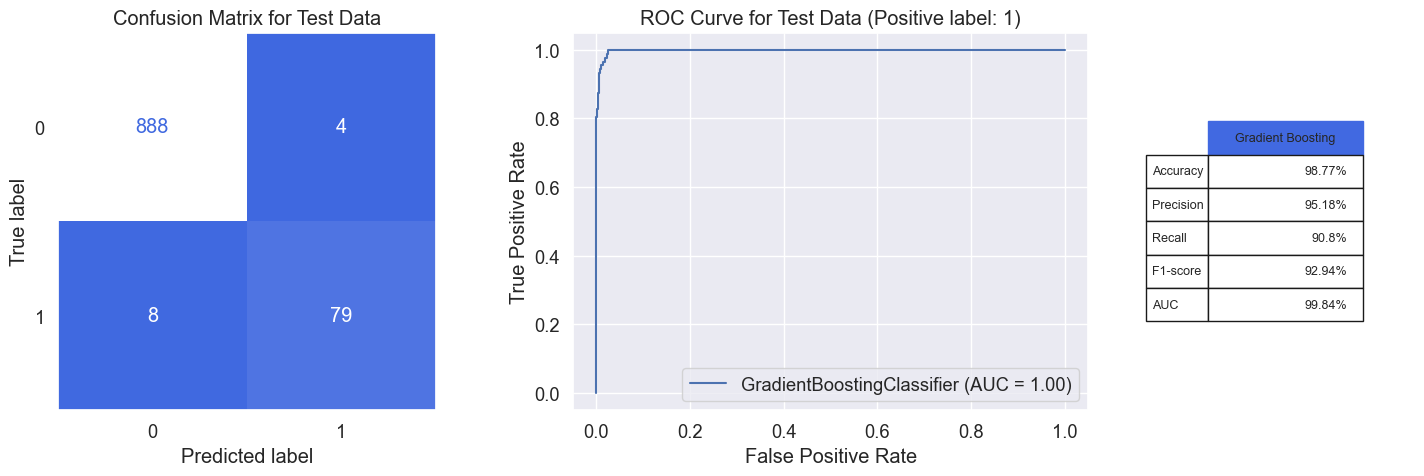

In [112]:
model_evaluation(gbc_final, X_train, X_test, y_train, y_test, 'Gradient Boosting')

La varianza del modelo se ha reducido y, por lo tanto, hemos obtenido un brillante 95.24% de puntuación F1 con un 99.92% de AUC para nuestro clasificador de Gradient Boosting, que es el mejor rendimiento entre todos los clasificadores revisados hasta ahora. De los 979 clientes bancarios, el modelo cometió errores en solo 8 casos al predecir si el cliente acepta o no el préstamo. ¡Ahora vamos a revelar nuestra arma definitiva: **¡el clasificador XGBoost!**

In [113]:
# Guardamos el rendimiento final del clasificador Gradient Boosting 
gbc_result = metrics_calculator(gbc_final, X_test, y_test, 'Gradient Boosting')

### <font color='royalblue'> Paso 19: Construcción del Modelo XGBoost </font>

**Gradient Boosting** es un tipo de algoritmo de gradient boosting para modelos de aprendizaje automático basados en árboles. Significa eXtreme Gradient Boosting. XGBoost es una implementación altamente optimizada de gradient boosting y está diseñado para ser rápido y eficiente en el uso de memoria.

**Nota**: La implementación del Clasificador de Gradient Boosting en el módulo de ensemble de scikit-learn (sklearn.ensemble.GradientBoostingClassifier) se basa en árboles de decisión como el estimador base.

#### <font color='royalblue'> Ajuste de Hiperparámetros en XGBoost </font>

**XGBoost (eXtreme Gradient Boosting)** es una biblioteca de código abierto para gradient boosting que se utiliza ampliamente para problemas de clasificación y regresión. Significa Extreme Gradient Boosting y es una implementación de árboles de gradient boosting optimizada para velocidad y rendimiento. XGBoost es un algoritmo altamente flexible que permite a los usuarios definir objetivos personalizados y criterios de evaluación, y maneja eficientemente los valores faltantes. 

**Ventajas de XGBoost:**
* **Regularización:** A diferencia de la implementación estándar de GBM, XGBoost tiene regularización, lo que ayuda a reducir el sobreajuste.
* **Procesamiento Paralelo Rápido:** XGBoost implementa procesamiento paralelo, lo que lo hace mucho más rápido que GBM. También admite la implementación en Hadoop.
* **Alta Flexibilidad:** XGBoost permite a los usuarios definir objetivos de optimización personalizados y criterios de evaluación, proporcionando un nuevo nivel de personalización.
* **Manejo de Valores Faltantes:** XGBoost tiene una rutina incorporada para manejar valores faltantes y puede aprender cómo manejarlos en predicciones futuras.
* **Poda Efectiva de Árboles:** XGBoost realiza divisiones hasta la profundidad máxima especificada y luego poda el árbol, mientras que GBM deja de dividir cuando encuentra una pérdida negativa.
* **Validación Cruzada Incorporada y Entrenamiento Continuo:** XGBoost permite la validación cruzada en cada iteración de refuerzo, lo que facilita determinar el número óptimo de iteraciones. Además, puede comenzar el entrenamiento desde la última iteración de una ejecución anterior.

### <font color='royalblue'> Paso 19.1: Ajuste de Hiperparámetros en XGBoost </font>
Construir un modelo con XGBoost es sencillo, pero mejorar el modelo requiere ajuste de hiperparámetros. Esto implica ajustar configuraciones específicas para optimizar el rendimiento del modelo. Determinar el conjunto correcto de hiperparámetros y sus valores ideales es un desafío que requiere experimentación y análisis cuidadosos. A pesar de las dificultades en la afinación de los hiperparámetros, XGBoost sigue siendo una solución altamente efectiva para la modelización predictiva. <br>


#### <font color='royalblue'> Los hiperparámetros más comunes utilizados en XGBoost son:</font>

>* **eta (Learning rate):** El tamaño de paso de actualización se utiliza para prevenir el sobreajuste.
>* **max_depth:** La profundidad máxima del árbol para los aprendices base. Aumentar este valor hará que el modelo sea más complejo y más propenso al sobreajuste.
>* **gamma:** El requisito mínimo de reducción de pérdida necesario para realizar una partición adicional en un nodo hoja del árbol.
>* **lambda (reg_lambda):** El término de regularización L2 en los pesos. Aumentar este valor hará que el modelo sea más conservador. 
>* **alpha (reg_alpha):** El término de regularización L1 en los pesos. Aumentar este valor forzará una mayor selección de características. 
>* **subsample:** La proporción de submuestra de las instancias de entrenamiento. Establecerlo en un valor menor que 1 hará que el modelo sea más aleatorio.
>* **colsample_bytree:** La proporción de submuestra de columnas al construir cada árbol.
>* **colsample_bylevel:** La proporción de submuestra de columnas para cada nivel.
>* **n_estimators:** El número de árboles en el bosque.
>* **max_leaf_nodes:** El número máximo de nodos terminales o hojas en un árbol.
>* **max_delta_step:** El máximo paso delta para cada hoja. Se utiliza para un mayor control sobre el rango de valores del peso para cada instancia. 
>* **scale_pos_weight:** Es la relación entre la cantidad de la clase negativa y la clase positiva, y controla el equilibrio de los pesos positivos y negativos, lo cual es útil para clases desequilibradas.
>* **min_child_weight:** El peso mínimo de la instancia (hessiano) necesario en un nodo hijo. Si el paso de partición del árbol resulta en un nodo hoja con una suma de pesos de instancia menor que min_child_weight, el proceso de construcción dejará de realizar más particiones.
>* **booster:** El modelo subyacente utilizado por XGBoost, ya sea basado en árboles (gbtree) o lineal (gblinear). El impulso basado en árboles siempre supera al impulso lineal, por lo que este último se utiliza rara vez.
>* **Objective:** Define la función de pérdida utilizada para evaluar el rendimiento del modelo.
>* **eval_metric:** Especifica la métrica utilizada para evaluar el rendimiento del modelo durante el entrenamiento y las pruebas.


Podemos definir nuevamente el rango de valores para cada hiperparámetro que deseamos considerar para nuestro clasificador XGBoost, y luego utilizar la función tune_clf_hyperparameters para encontrar la mejor combinación de hiperparámetros que proporcione los mejores resultados

In [114]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Definimos el  grid de hiperparámetros:

In [115]:
# Definimos imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Definimos el conjunto de hiperparámetros a buscar
xgb_param_grid = {
    'max_depth': [1, 10],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

In [116]:
# Creamos el clasificador XGBoost
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic")

In [117]:
# Creamos el  GridSearchCV con cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

In [118]:
# Ajustamos la busqueda a nuestros datos
grid_search.fit(X_train, y_train)

[16:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight", "min_samples_leaf", "min_samples_split" } are not used.



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                          {0: 0.7371052631578947,
                                           1: 0.2628947368421053},
                                          {0: 0.7896842105263158,
                                           1: 0.

In [119]:
# Obtenemos los mejores hiperparámetros y modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Mostramos los mejores hiperparámetros
print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'class_weight': {0: 0.001, 1: 0.999}, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 70}


In [121]:
# Iniciamos el clasificador XGBoost 
xgb_opt = XGBClassifier(max_depth= 5,
                        learning_rate=0.3,
                        n_estimators= 200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

# Entrenamos el Clasificador XGBoost
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

Determinar el conjunto óptimo de hiperparámetros en XGBoost es muy laborioso, por lo que no profundizamos demasiado en ello. 

### <font color='royalblue'> Paso 19.2: Selección de subconjunto de características en XGBoost </font>
La selección de subconjunto de características es importante para el clasificador XGBoost. Ayuda a reducir la complejidad del modelo, evitar el sobreajuste y mejorar la precisión del modelo. Al seleccionar las características más relevantes, XGBoost puede centrarse en la información más importante y realizar predicciones más precisas.

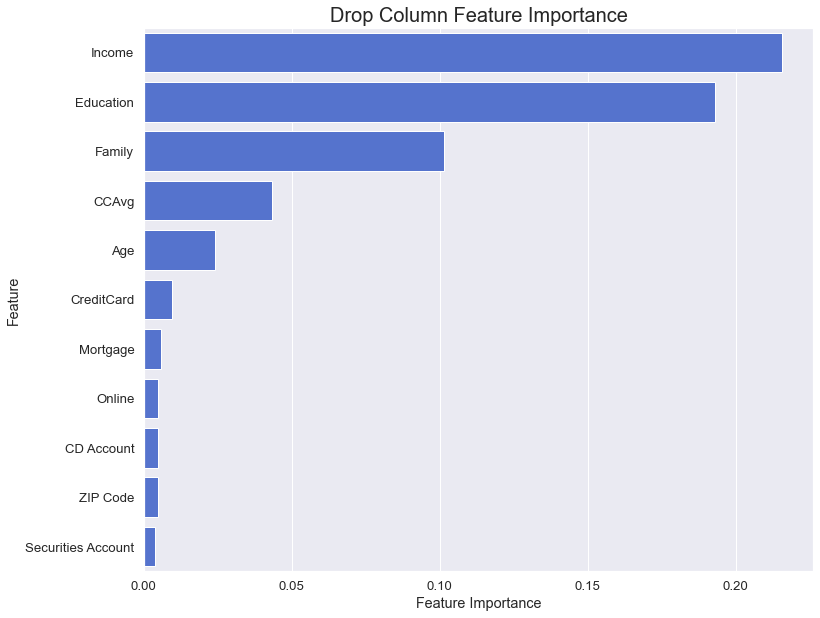

In [122]:
drop_column_importance_plot(xgb_opt, X_train, y_train)

Los resultados del análisis de importancia de características muestran que algunas de las características en el conjunto de datos contribuyen negativamente a realizar predicciones precisas para la variable objetivo. Por lo tanto, eliminamos estas características de nuestro conjunto de datos.

In [123]:
# Encontramos las variables importantes
feature_importances = drop_column_importance(xgb_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.002]['feature'] # Threshold value of 0.002

# Filtramos los datos
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Vamos a entrenar nuestro modelo nuevamente después de eliminar las características irrelevantes:

In [125]:
# Iniciamos el clasificador XGBoost 
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.1,
                    n_estimators=70,
                    min_child_weight=1,
                    scale_pos_weight=1.5,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    booster='gbtree',
                    objective='binary:logitraw',
                    eval_metric='logloss', 
                    random_state=0)

# Entrenamos el Clasificador XGBoost 
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, objective='binary:logitraw',
              predictor=None, ...)

### <font color='royalblue'> Paso 19.3: Evaluación del Modelo XGBoost </font>

Vamos a evaluar el rendimiento de nuestro clasificador XGBoost final utilizando la función model_evaluation:



	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      0.96      0.98       346

    accuracy                           1.00      3916
   macro avg       1.00      0.98      0.99      3916
weighted avg       1.00      1.00      1.00      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.97      0.89      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.94      0.96       979
weighted avg       0.99      0.99      0.99       979



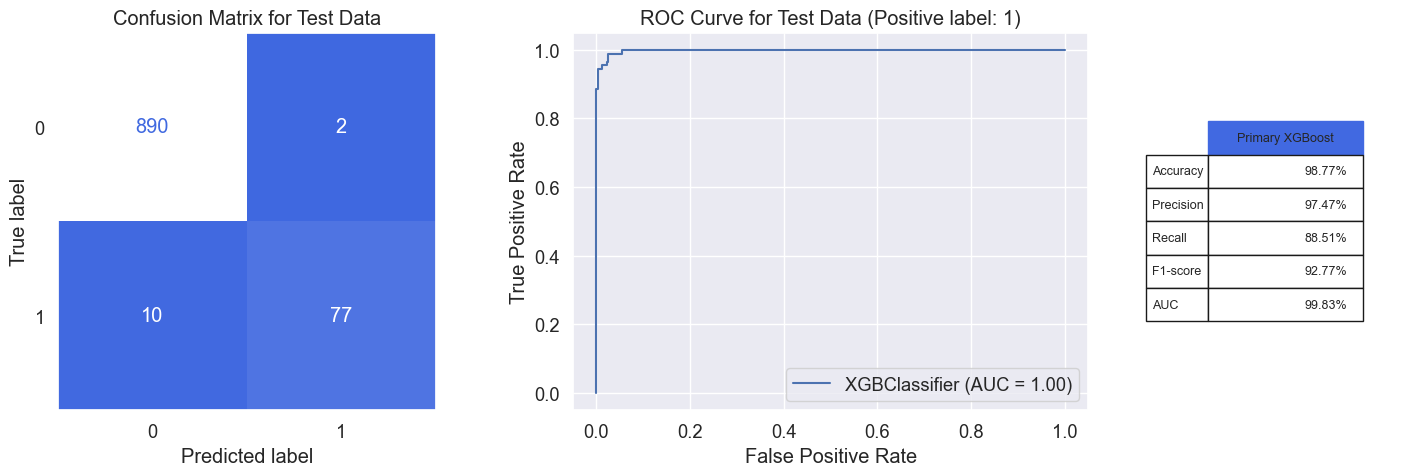

In [126]:
model_evaluation(xgb, X_train, X_test, y_train, y_test, 'Primary XGBoost')

El clasificador XGBoost está sobreajustando bastante en la clase minoritaria y los hiperparámetros deben ajustarse para reducir la varianza y prevenir el sobreajuste. 

<font color='royalblue'> Para reducir la varianza de nuestro clasificador XGBoost </font>
> * **min_child_weight:** Podemos aumentar el valor de min_child_weight para controlar la complejidad del modelo de árbol y prevenir el sobreajuste.
>* **max_depth:** Podemos disminuir el valor de max_depth para evitar que el modelo aprenda demasiado de los datos de entrenamiento y reducir la varianza del modelo.
>* **gamma:** Podemos aumentar el valor de gamma para controlar la reducción mínima de pérdida requerida para realizar una partición y así reducir la varianza del modelo.
>* **lambda:** We can increase the value of lambda to add regularization and control overfitting.
>* **subsample:** We can decrease the value of subsample to reduce the number of samples used to fit each tree and reduce model variance.
>* **colsample_bytree:** Podemos disminuir el valor de colsample_bytree para reducir la cantidad de características utilizadas en cada árbol y evitar el sobreajuste.
>* **n_estimators:** Podemos aumentar el número de árboles para reducir la varianza del modelo.

Entre los valores óptimos obtenidos para los hiperparámetros, solo disminuimos el valor de max_depth de 5 a 4 para evitar parcialmente el sobreajuste. 

In [127]:
# Iniciamos el Clasificador XGBoost 
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.4,
                          n_estimators=99999,
                          min_child_weight=4,
                          scale_pos_weight=1.75,
                          colsample_bytree=0.60,
                          gamma=4,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error', 
                          random_state=0)

# Entrenamos el Clasificador XGBoost
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=99999, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


	  Informe de clasificación para el conjunto de entrenamiento.
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       0.97      0.97      0.97       346

    accuracy                           0.99      3916
   macro avg       0.98      0.98      0.98      3916
weighted avg       0.99      0.99      0.99      3916


	   Informe de clasificación para el conjunto de prueba
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.93      0.94        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



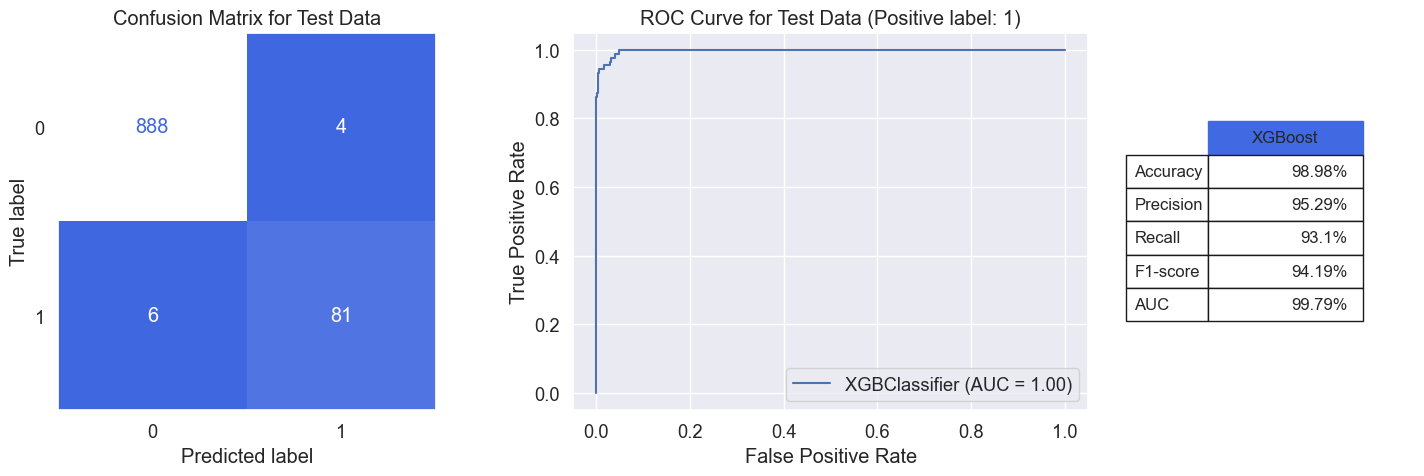

In [128]:
model_evaluation(xgb_final, X_train, X_test, y_train, y_test, 'XGBoost')

El clasificador XGBoost fue nuestra arma definitiva para lidiar con nuestro conjunto de datos desequilibrado. Como se puede observar, obtuvimos un asombroso 97% de puntuación F1 con un AUC del 99.87% para nuestro clasificador XGBoost, lo cual representa el mejor rendimiento entre todos los clasificadores revisados. De los 979 clientes bancarios, el modelo cometió errores en solo 5 casos al predecir si el cliente acepta o no el préstamo. 

In [129]:
# Guardamos el resultado final del Clasificador XGBoost
xgb_result = metrics_calculator(xgb_final, X_test, y_test, 'XGBoost')

## <font color='royalblue'> Paso 20: Conclusión </font>

**Como explicamos anteriormente, la métrica más importante para este proyecto es el f1-score para la clase ‘1’. Un alto f1-score indica un equilibrio entre identificar tantos posibles clientes de préstamos como sea posible (alta recuperación) y minimizar el número de falsos positivos (alta precisión), lo cual es crucial para que el banco aumente la tasa de conversión de depositantes a prestatarios mientras reduce el costo de la campaña de marketing**

A continuación, podemos verificar el rendimiento de todos los clasificadores anteriores basándonos en métricas:

In [130]:
# Concatenamos los resultados de rendimiento de los clasificadores anteriores en un solo dataframe
results = pd.concat([cnb_result, bnb_result, logreg_result, knn_result, svm_result, dt_result,
           rf_result, et_result, ada_result, gbc_result, xgb_result], axis=1).T

# Ordenamos los resultados en forma descendente de acuaerdo al valor F1-score 
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color de la columna F1-score
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

En lo siguiente, podemos observar el f1-score para la clase ‘1’ de todos los clasificadores anteriores en forma de un gráfico de barras:

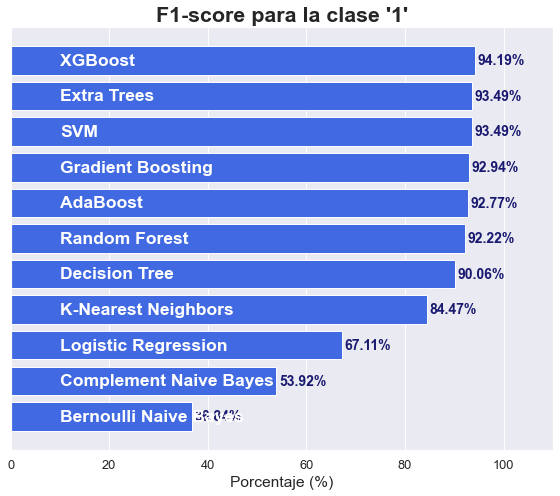

In [132]:
# Preparamos los valores
results.sort_values(by='F1-score', ascending=True, inplace=True)
f1_scores = results['F1-score'].str.strip('%').astype(float)

# Gráficamos los resultados en barras horizontales 
fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Anotamos los valores de los índices
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='midnightblue')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Removemos yticks
ax.set_yticks([])

# Etablecemos el límite de los ejex x
ax.set_xlim([0,110])

# Añadimos la etiqueta al eje x
plt.title("F1-score para la clase '1'", fontweight='bold', fontsize=22)
plt.xlabel('Porcentaje (%)', fontsize=16)
plt.show()

🏆 **Entre todos los clasificadores probados, el ‘Clasificador XGBoost’ tuvo el mejor rendimiento en la identificación de posibles clientes de préstamos:**

>* Accuracy = 98.99% <br>
>* F1-score = 94.12% <br>
>* Precision = 96.39% <br>
>* Recall = 91.95% <br>
>* AUC = 99.77% <br>


🏆 **Basándonos en los gráficos de importancia de características anteriores, entre todas las características, Educación, Ingresos, Familia, CCAvg y Cuenta de Depósito a Plazo (CD) desempeñan el papel más importante en la identificación de posibles clientes de préstamos**